In [1]:
import pandas, os
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.gridspec as gridspec
import pylab

In [2]:
def get_dataframes(df_path_list):
    dfs = []
    for df_path in df_path_list:
        dfs.append(pandas.read_csv(df_path))
    df = pandas.concat(dfs)
    return df

def refactor_data(df):
    df = df.replace("singleMachine", "   SingleMachine")
    df = df.replace("distributedBaseline", "  NoisyCounts")
    df = df.replace("localRNM", " LocalRNM")
    return df

def load_results(root_dir):
    file_exps = os.listdir(root_dir)
    exps = []
    for file in file_exps:
        exps.append(os.path.join(root_dir, file))
    df = get_dataframes(exps)
    return refactor_data(df)


In [3]:
df = load_results("aws_results")

In [4]:
COLORS = [
#     (1,0.647,0), 
#     (1, 0, 0), 
#     (0.84, 0.55, 0.97), 
#     (0, 1, 0)
    (0.95, 0.59, 0.31), # orange
    (0.56, 0.42, 0.72), # purple
    (0.78, 0.24, 0.22), # red
    (0.22, 0.47, 0.69), # blue
    (0.255, 0.518, 0.2), # forest green
    (0.34, 0.74, 0.80), # cyan
]

LINESTYLES = ['--', ':']
MARKERS = ['v', 'o', '^'] #'.', '<', '>']     

In [5]:
import random

    
ALPHA_LOW = 0.3
ALPHA_HIGH = 1.0

def val_eq(a, b):
    assert type(a) == type(b)
    assert type(a) in [np.float64, str, int], "invalid type: %s" % (type(a))
    if isinstance(a, str) or isinstance(a, int):
        return a == b
    else:
        return abs(a-b) < 1e-10

import itertools

"""Base generator that gives each color a distinct linestyle/markers pair"""
class BaseGenerator:
    def __init__(self, cols, linestyles, markers):
        assert len(cols) == len(linestyles) * len(markers)
        random.seed(42)
        # each color gets a distinct linestyle/markers pair
        style_list = []
        i = 0
        for linestyle in linestyles:
            for marker in markers:
                style_list.append((cols[i], linestyle, marker))
                i += 1
        self.gen_list = style_list
        self.sampled = set()
        
    def __call__(self):
        idx = random.randint(0, len(self.gen_list)-1)
        while (idx in self.sampled):
            if len(self.sampled) == len(self.gen_list):
                break
            idx = random.randint(0, len(self.gen_list)-1)
        self.sampled.add(idx)
        return self.gen_list[idx]
        
"""Suppose tup is a tuple of zaxis features. Sometimes, we might want to
give difference tup's the same color, but different shades, to denote groups. 
This class gives colors based on the values of tup[0] (that is, assumes
first element of tuple determines the color_alpha value).
"""
class ColorAlphaGenerator(BaseGenerator):
    def __init__(self, cols, linestyles, markers, alpha_keys):
        super().__init__(cols, linestyles, markers)
        self.tup2res = dict()
        self.alpha_keys = sorted(alpha_keys)
        
    # rank alphas; higher the key higher the alpha.
    def alpha_key2val(self, alpha_key):
        n = len(self.alpha_keys)
        for i, key in enumerate(self.alpha_keys):
            if val_eq(key, alpha_key):
                # i in [0, n-1]; alpha in [ALPHA_LOW, ALPHA_HIGH]
                return float(i) / (n-1) * (ALPHA_HIGH-ALPHA_LOW) + ALPHA_LOW
        assert False, "%s not found in %s" % (alpha_key, self.alpha_keys)
        
    def __call__(self, tup):
        # first element in tup is the alpha_key
        alpha_val = self.alpha_key2val(tup[0])
        rest = tup[1:]
        if rest not in self.tup2res:
            self.tup2res[rest] = super().__call__()
        return (alpha_val, *self.tup2res[rest])

In [6]:
"""
These should take in a Dataframe which has been called groupby on the xaxis. 
Therefore, any aggregation done will be over the n experiments per datapoint.
low, high mark the error bands. mid is the value to plot.
"""
def percentiles(groupby):
    low = groupby.quantile(0.25)
    mid = groupby.quantile(0.5)
    high = groupby.quantile(0.75)
    return low, mid, high

def mean_std(groupby):
    mean = groupby.mean()
    std = groupby.std()
    return mean-std, mean, mean+std

def mean_std_err(groupby):
    mean = groupby.mean()
    stderr = groupby.sem()
    return mean - stderr, mean, mean + stderr

In [7]:
import itertools

# element-wise tuple multiplication
def tup_mul(tup, m):
    return tuple([m*x for x in tup])

# get the number of experiments and verify that they're the same for this plot
# (we don't want some points in this plot to have different number of experiments than others)
def get_num_exps(groupby):
    assert not groupby.count().empty, "count aggregation turns out to be empty"
    counted = groupby.count().values.reshape(-1)
#     print(groupby.count())
#     assert np.all(counted == counted[0]), "some points in plot have diff num of exps; counts = %s" % counted
    return counted[0]

BSLN_IND = {
    "alpha": -1.,
}

TITLE_SIZE = 25
TICKS_SIZE = 20
LEGEND_SIZE = 23
AXIS_SIZE = 22
LINE_WIDTH = 5
MARKER_SIZE = 10
ERROR_BAND_ALPHA = 0.2
LEGEND_HANDLE_LENGTH = 2
LEGEND_LINE_WIDTH = 5
LEGEND_LOC = "center" # "lower center"

# inputted df should be only for the specific subplot and zaxis values.
def singleplot(ax, df, xaxis, yaxis, color_alpha, color, linestyle, marker, label):
    assert df.keys().tolist() == [xaxis, yaxis], "df.keys().tolist() = %s != %s" % (df.keys().tolist(), [xaxis, yaxis])
    groupby = df.groupby(xaxis)
    
    # mark number of experiments and label
    num_exps = get_num_exps(groupby)
    
    # low, mid, high = percentiles(groupby)
    low, mid, high = mean_std_err(groupby)
 
    # if there is a baseline to plot, plot it with solid line
    if xaxis in BSLN_IND:
        bsln_val = BSLN_IND[xaxis]
        low_bsln = low.loc[bsln_val].values.item()
        mid_bsln = mid.loc[bsln_val].values.item()
        high_bsln = high.loc[bsln_val].values.item()
        low = low.drop(bsln_val)
        mid = mid.drop(bsln_val)
        high = high.drop(bsln_val)
        
        ax.axhline(mid_bsln, linewidth=LINE_WIDTH, markersize=MARKER_SIZE, color=color, linestyle='-', marker=marker)# , label=label)
        ax.axhspan(high_bsln, low_bsln, facecolor=color, alpha=ERROR_BAND_ALPHA)
    
    # plot the middle and low, high are the error band
    xs = mid.index.values
    # color diluted by alpha (as in RGBA)
    ax.semilogx(xs, mid.values.ravel(), linewidth=LINE_WIDTH, markersize=MARKER_SIZE, color=tup_mul(color, color_alpha), linestyle=linestyle, marker=marker, label=label)
    ax.fill_between(xs, high.values.ravel(), low.values.ravel(), facecolor=color, alpha=ERROR_BAND_ALPHA)

# these are columns that can be duplicated
metric_cols = ['seed', 'testAcc', 'trainAcc', 'trainingTime', 'evaluationTime', 
                'numNodes', 'maxDepth', 'maxAchievedDepth']

# the last row should be centered
# if parity of num_cols and remainder is the same, then it's easy
# otherwise, make them the same by doubling both. 
def create_fig(num_cols, num_subplots):
    num_rows = (num_subplots+num_cols-1) // num_cols
    num_rem = num_subplots - (num_rows-1)*num_cols # for the last row
    axs = []
    s = (8, 8)
    fig = plt.figure(figsize=(s[0]*num_cols,s[1]*num_rows), constrained_layout=False)
    gs = fig.add_gridspec(nrows=num_rows, ncols=2*num_cols)
    # 0,...,num_rows-2 are full
    for i in range(num_rows-1):
        for j in range(num_cols):
            axs.append(fig.add_subplot(gs[i, 2*j:2*j+2]))            
    # center the last row
    start = num_cols - num_rem
    for i in range(num_rem):
        axs.append(fig.add_subplot(gs[num_rows-1, start+2*i:start+2*i+2]))    
    return fig, axs

    
# subplot_axis is printing 
def multiplot(num_cols, df, fixed_axises, subplot_axis, xaxis, yaxis, zaxises, use_color_alpha=False, plot_legend=False):
    assert isinstance(zaxises, list), "zaxises = %s must be a list of labels" % str(zaxises)
    assert isinstance(fixed_axises, dict), "fixed_axises must be a dict of key,val pairs to filter by"
    assert len(zaxises) >= 1
    
    # this is the axis where color shades changes
    alpha_axis = zaxises[0]
    
    # filter df first
    for col, val in fixed_axises.items():
        df = df.loc[df[col] == val]
    
    subplot_vals = sorted(df[subplot_axis].unique())
    fig, axs = create_fig(num_cols, len(subplot_vals))
    
    # loop through subplots
    for i in range(len(subplot_vals)):
        ax = axs[i]
        subplot_df = df.loc[df[subplot_axis] == subplot_vals[i]]
        if use_color_alpha:
            styles_gen = ColorAlphaGenerator(COLORS, LINESTYLES, MARKERS, subplot_df[alpha_axis].unique())
        else:
            styles_gen = BaseGenerator(COLORS, LINESTYLES, MARKERS)
        
        # cross product over all possible value combinations of zaxises
        combinations = [sorted(subplot_df[zaxis].unique()) for zaxis in zaxises]
        for tup in itertools.product(*combinations):
            zaxis_df = subplot_df.copy()
            
            label = ""
            num_commas = 0
#             num_commas = len(zaxises)-1
            assert(len(zaxises) == len(tup))
            for j in range(len(zaxises)):
                # reverse order
                j = len(zaxises)-j-1
                key, val = zaxises[j], tup[j]
                zaxis_df = zaxis_df.loc[zaxis_df[key] == val]

                label += "%s" % val
                if num_commas < len(zaxises)-1:
                    label += ", "
                    num_commas += 1
                    
            # make sure nothing else is changing besides xaxis and yaxis
            for col in zaxis_df:
                if col not in [xaxis, yaxis] + metric_cols:
                    assert len(zaxis_df[col].unique()) == 1, \
                        "Column %s has more than 1 unique: %s" % \
                              (col, zaxis_df[col].unique())
            # get styles
            if use_color_alpha:
                alpha, color, linestyle, marker = styles_gen(tup)
            else:
                color, linestyle, marker = styles_gen()
                alpha = 1.
            singleplot(ax, zaxis_df[[xaxis, yaxis]], xaxis, yaxis, alpha, color, linestyle, marker, label)
        
        ax.tick_params(labelsize=TICKS_SIZE)
        ax.set_xlabel(xaxis, fontsize=AXIS_SIZE)
        ax.set_ylabel(yaxis, fontsize=AXIS_SIZE)
        ax.set_title("%s" % (subplot_vals[i]), fontsize=TITLE_SIZE)
        
    # one legend for everything! 
    handles, labels = axs[0].get_legend_handles_labels()
    # sanity check that all legends are indeed equal
    for ax in axs:
        hs, ls = ax.get_legend_handles_labels()
        assert len(labels) == len(ls), "mismatch labels lengths %d != %d" % (len(labels), len(ls))
        for i in range(len(labels)):
            assert labels[i] == ls[i], "mismatch labels idx = %d, %s != %s" % (i, labels[i], ls[i])
    
    # And make sure to filter values! (since we ignore alpha_axis)
    def get_key(k):
        k = k[0]
        return k
#         last_k = k.split(",")[-1][1:]
#         if last_k.isnumeric():
#             print("Number")
#             return float(last_k)
#         else:
#             return k
    by_label = dict(sorted(zip(labels, handles), key=get_key))
    fig.tight_layout(pad=3)
    fig.subplots_adjust(bottom=0.2)
    
    if plot_legend:
        fig_legend = plt.figure(figsize=(15, 15))
        fig_legend.add_subplot(111)
        leg = fig_legend.legend(by_label.values(), by_label.keys(), handlelength=LEGEND_HANDLE_LENGTH, 
                             loc=LEGEND_LOC, ncol=1, fontsize=LEGEND_SIZE, fancybox=True)
        for line in leg.get_lines():        
            line.set_linewidth(LEGEND_LINE_WIDTH)
            line.set_markersize(10)
            line.set_markeredgewidth(10)
    return fig

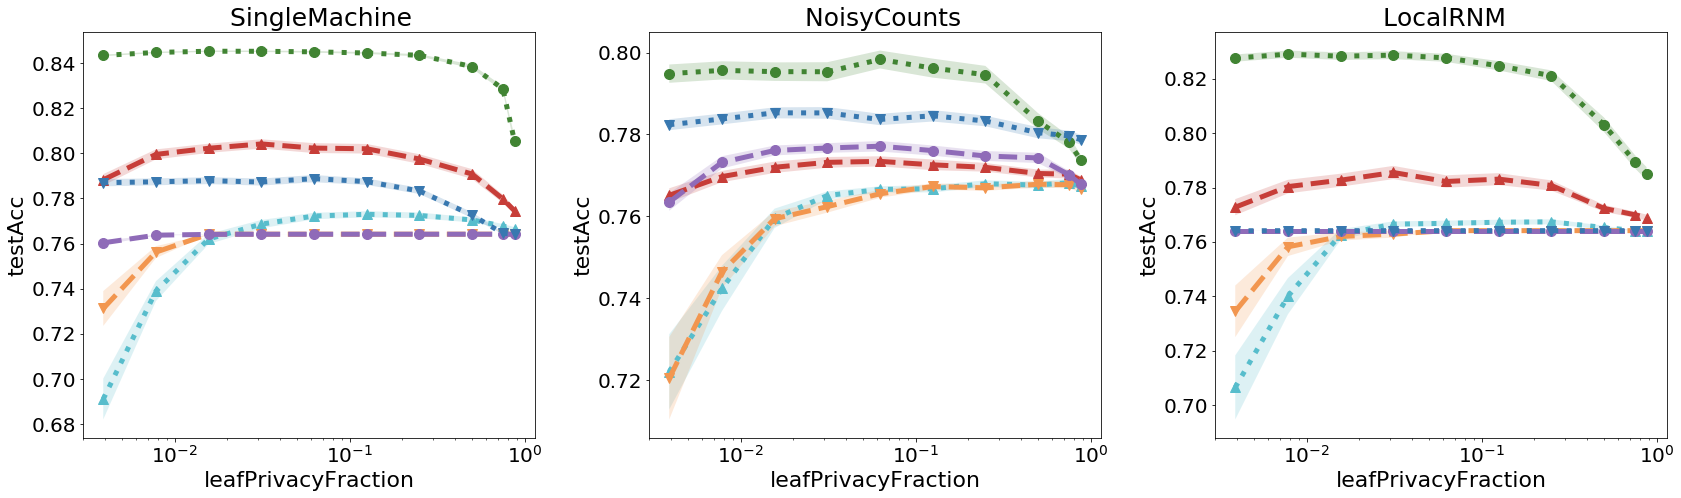

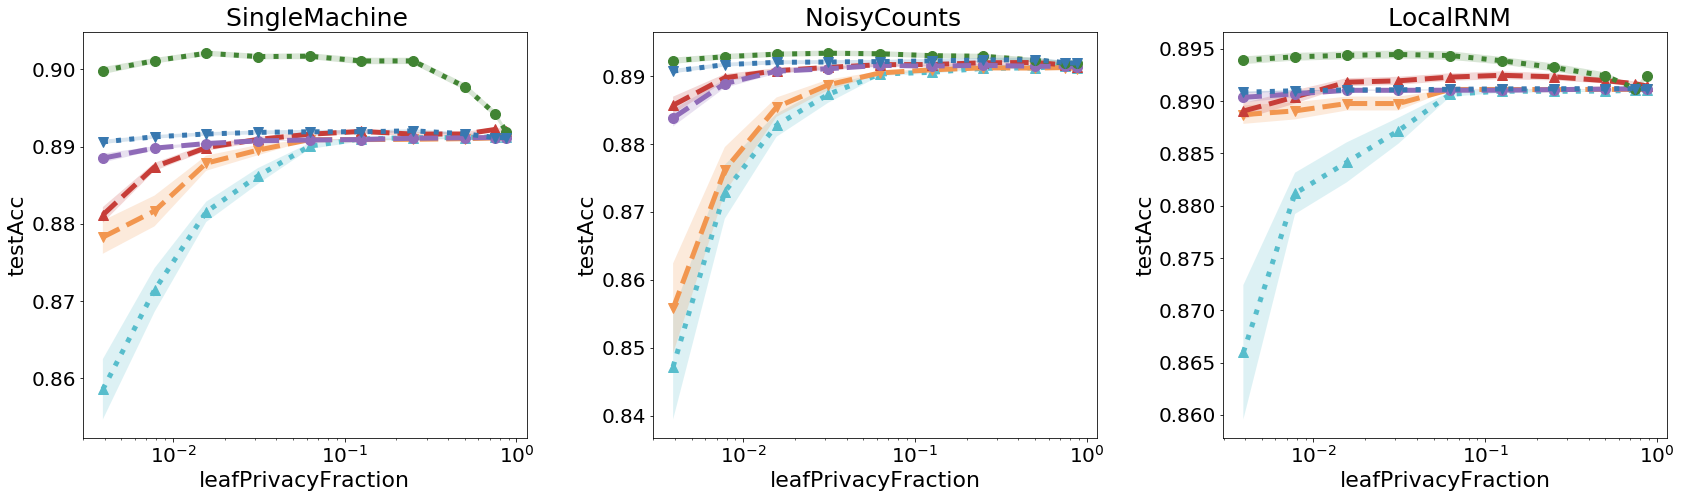

In [8]:
df3 = df[(df["alpha"] == 0.125) | (df["alpha"] == 1.0) | (df["alpha"] == 8)]

# For Figure 1
for dataset in ['adult', 'bank']:
    fig = multiplot(3, df3, fixed_axises={'trainingFraction': 1, 'dataset': dataset}, 
                subplot_axis='algo', xaxis='leafPrivacyFraction', yaxis='testAcc',
                zaxises=['alpha', 'budgetFn'], use_color_alpha=False, plot_legend=False)

creditcard
skin
mnist60k
kddcup
ctr


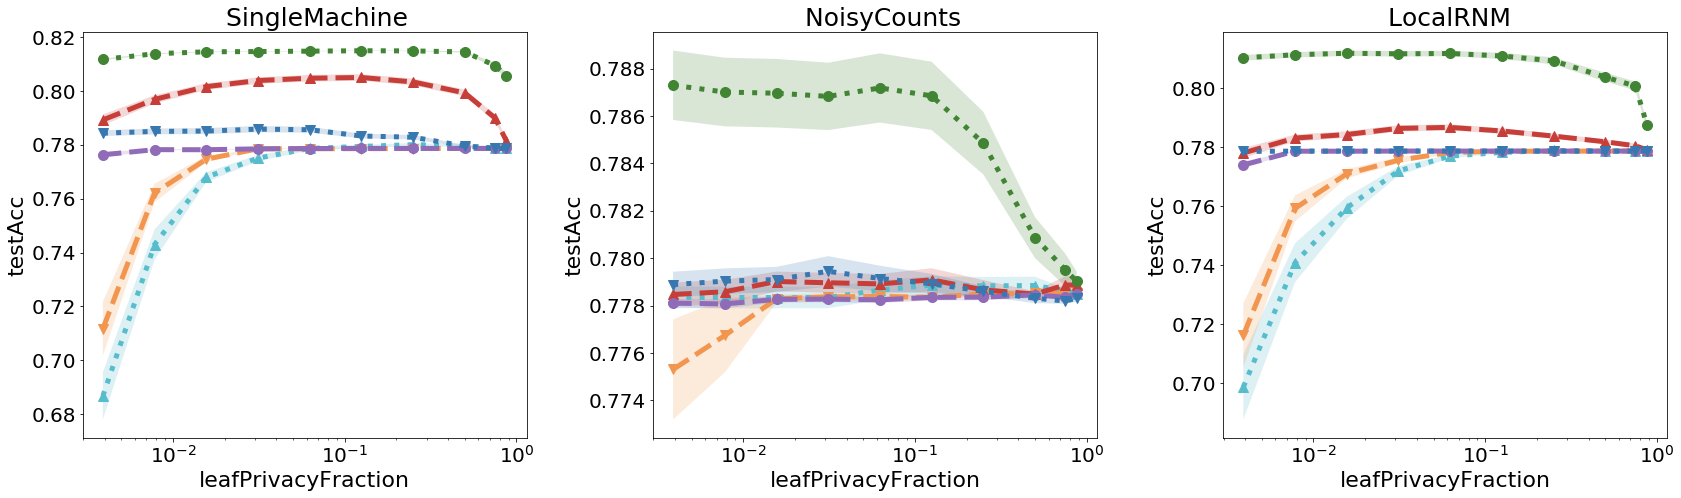

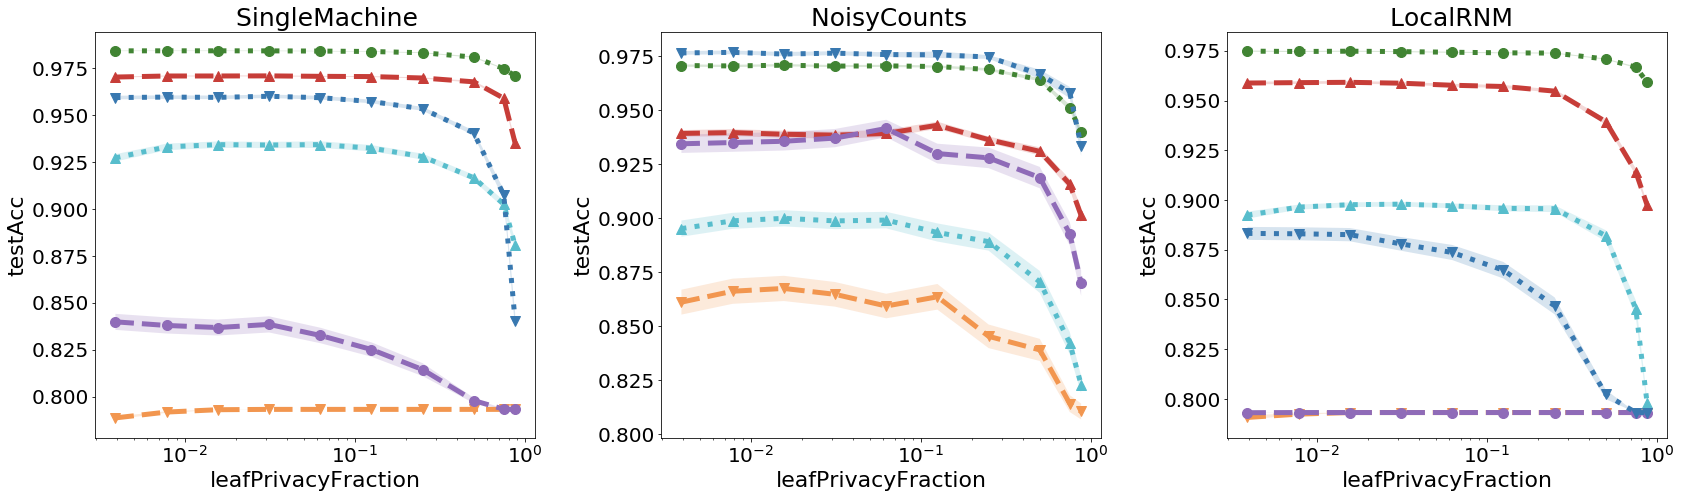

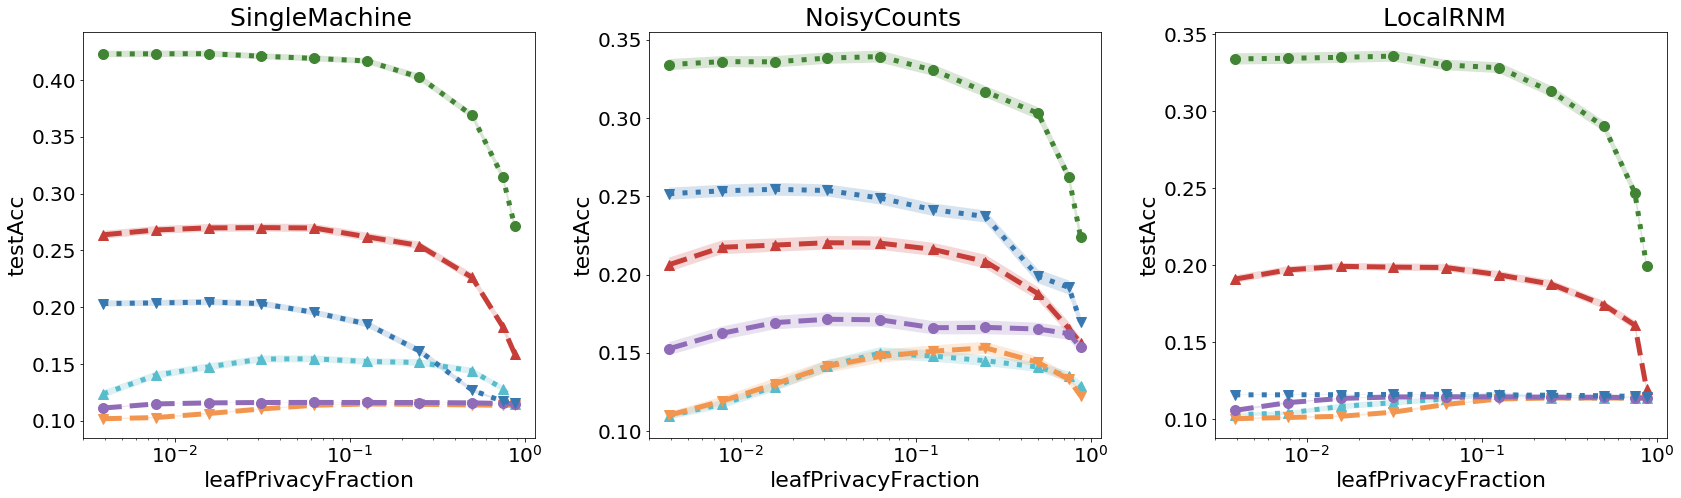

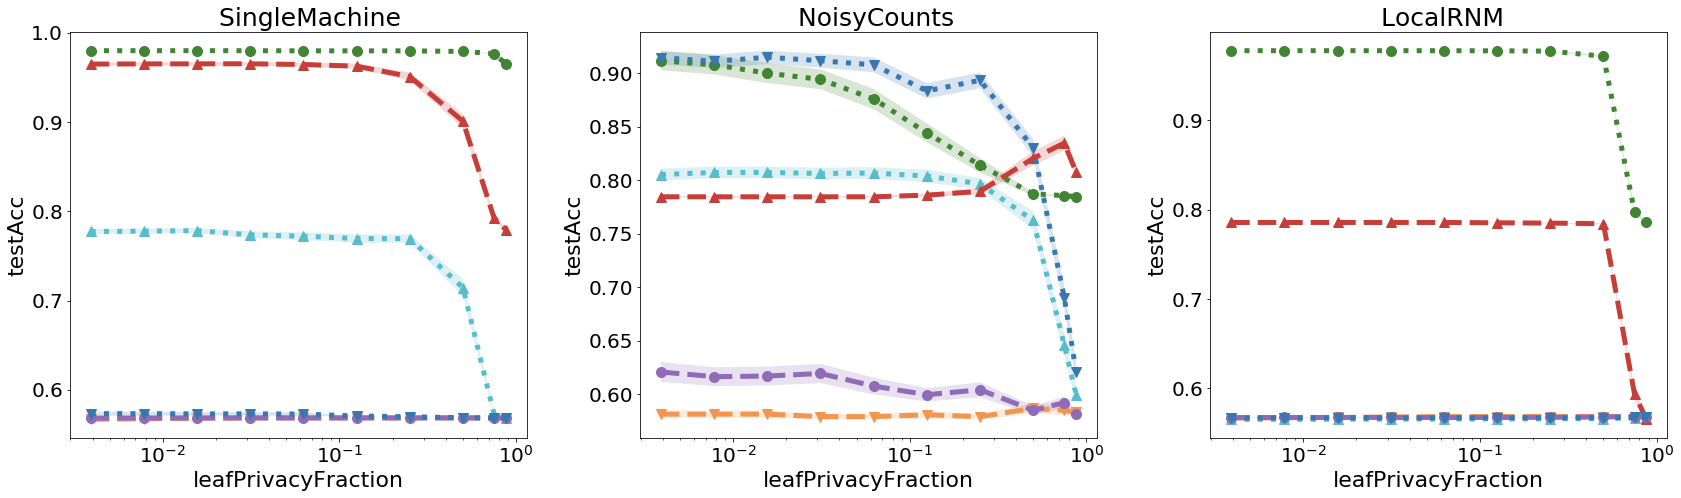

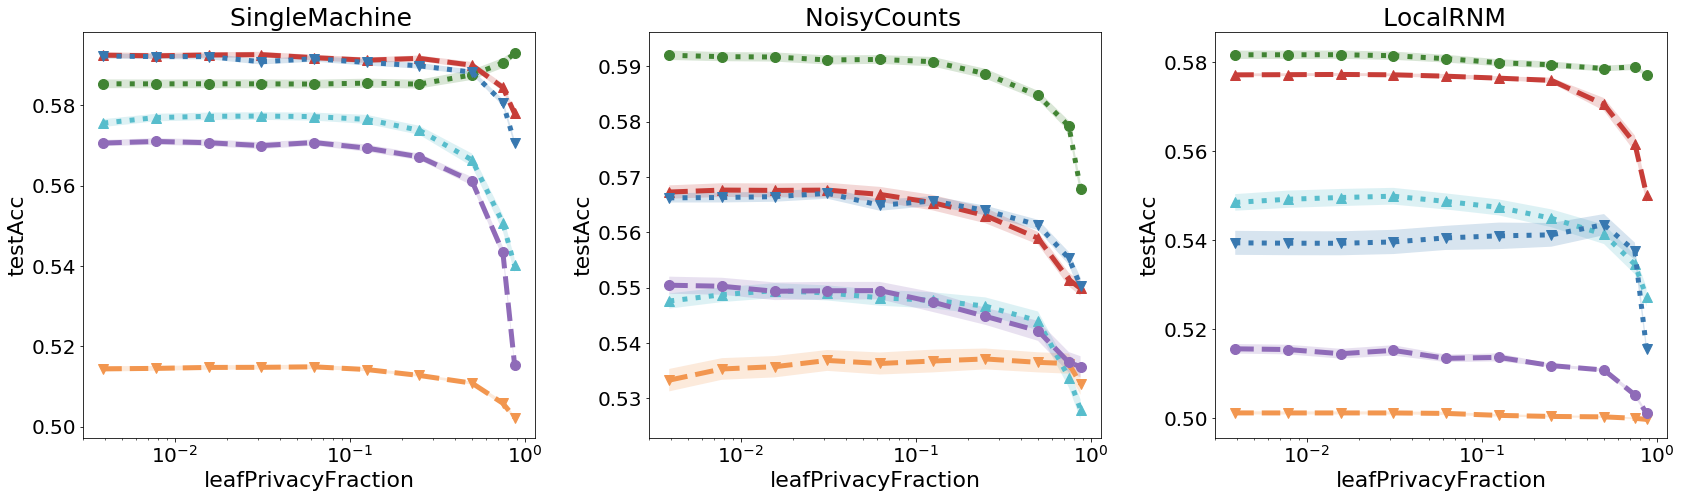

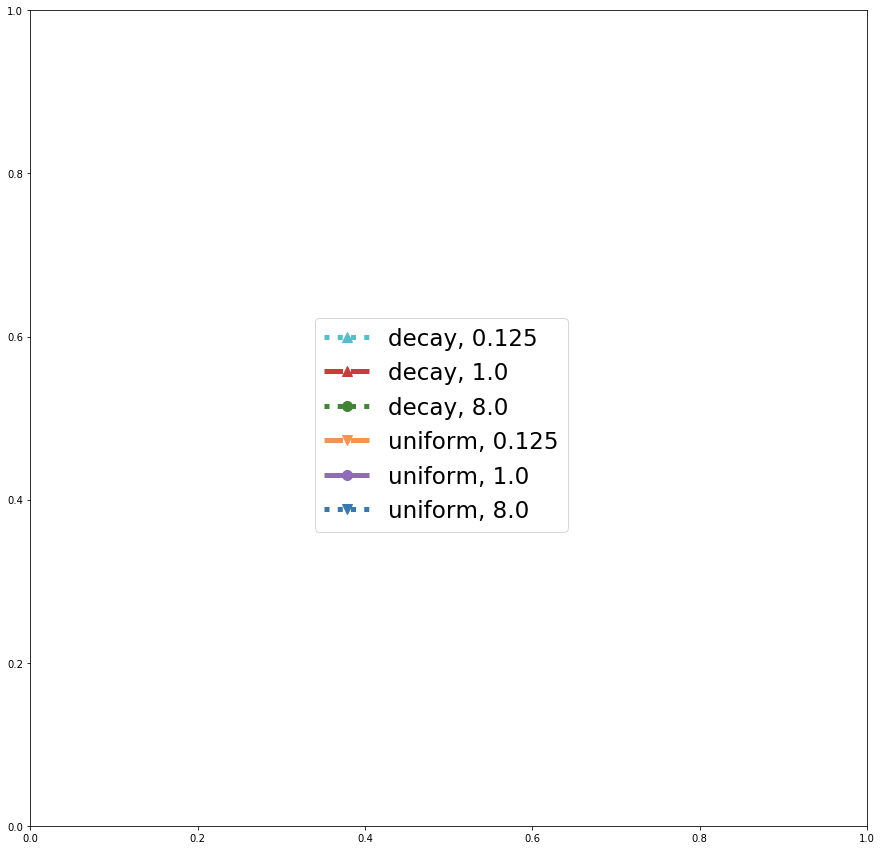

In [9]:
for dataset in ['creditcard', 'skin', 'mnist60k', 'kddcup', 'ctr']:
    print(dataset)
    plot_legend = False
    if dataset == 'ctr':
        plot_legend = True
    fig = multiplot(3, df3, fixed_axises={'trainingFraction': 1, 'dataset': dataset}, 
                subplot_axis='algo', xaxis='leafPrivacyFraction', yaxis='testAcc',
                zaxises=['alpha', 'budgetFn'], use_color_alpha=False, plot_legend=plot_legend)

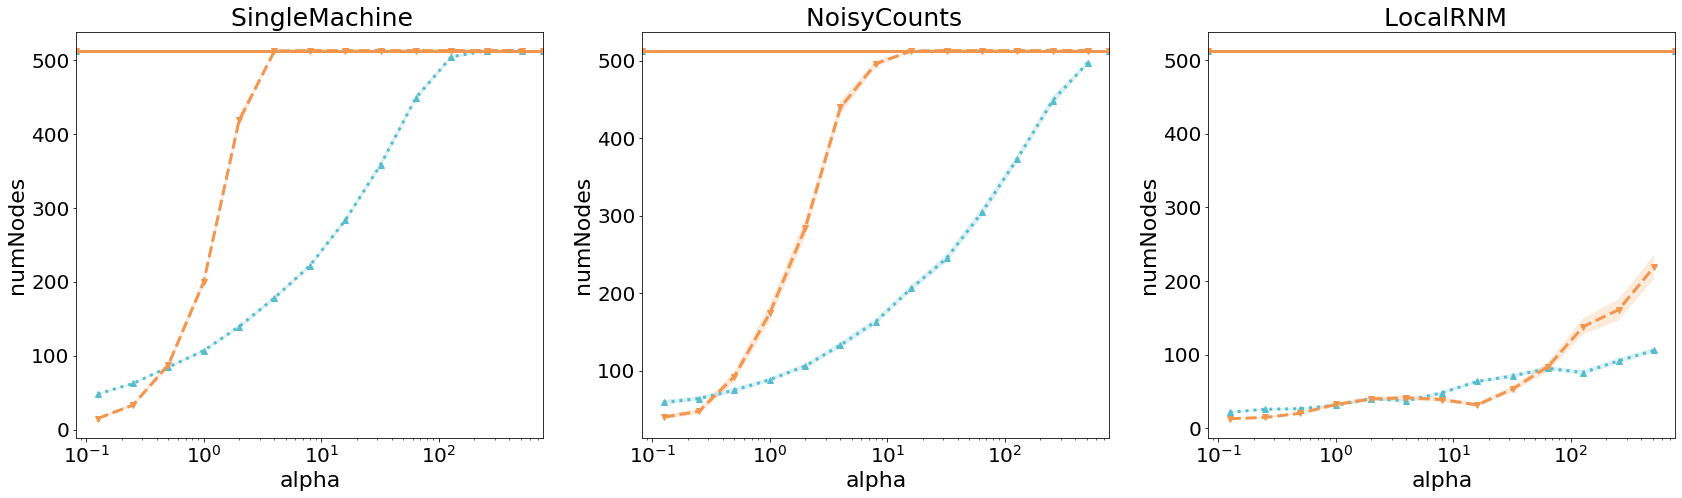

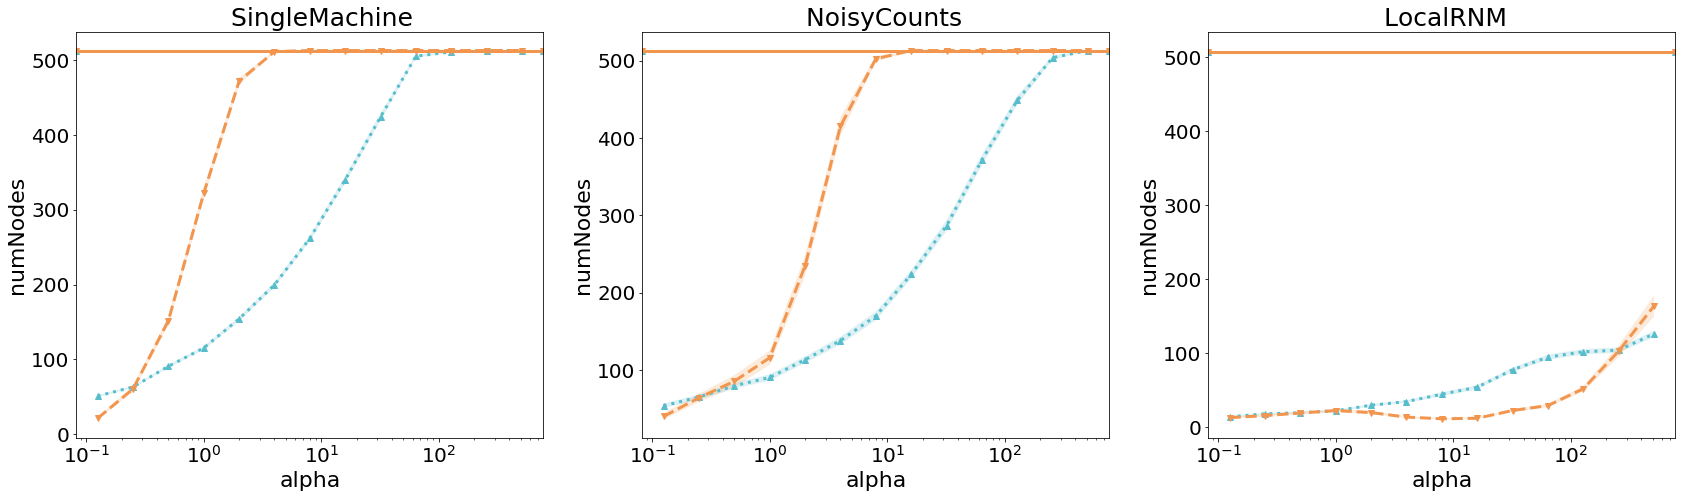

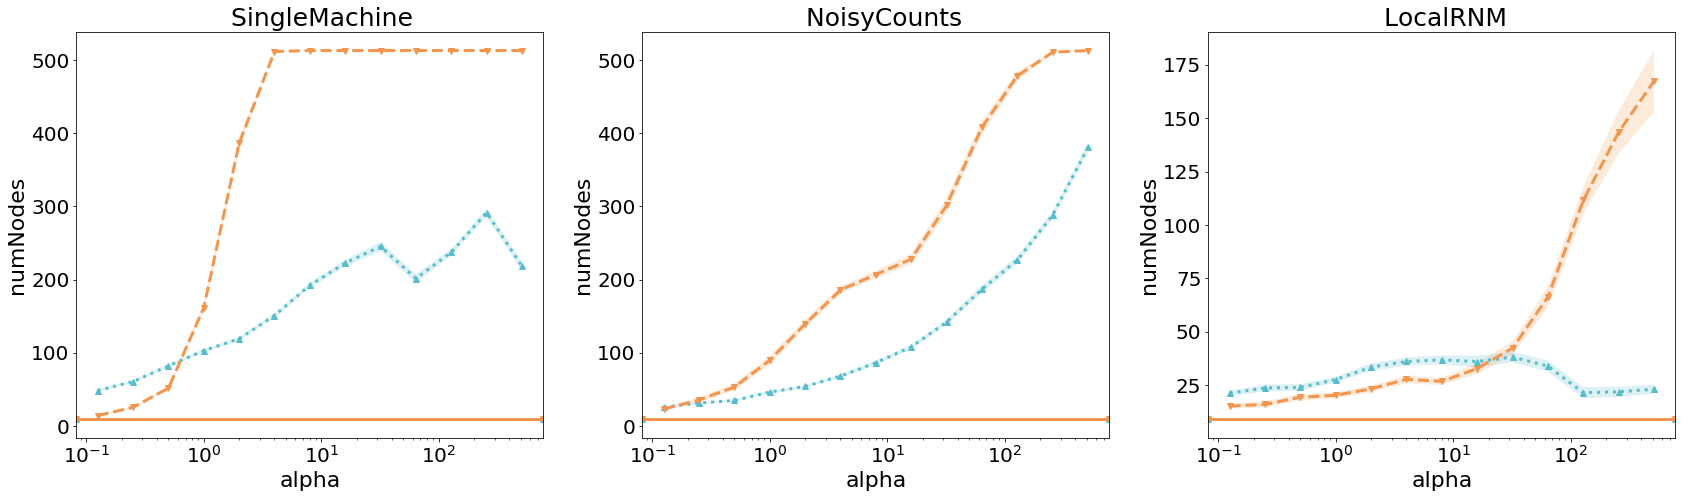

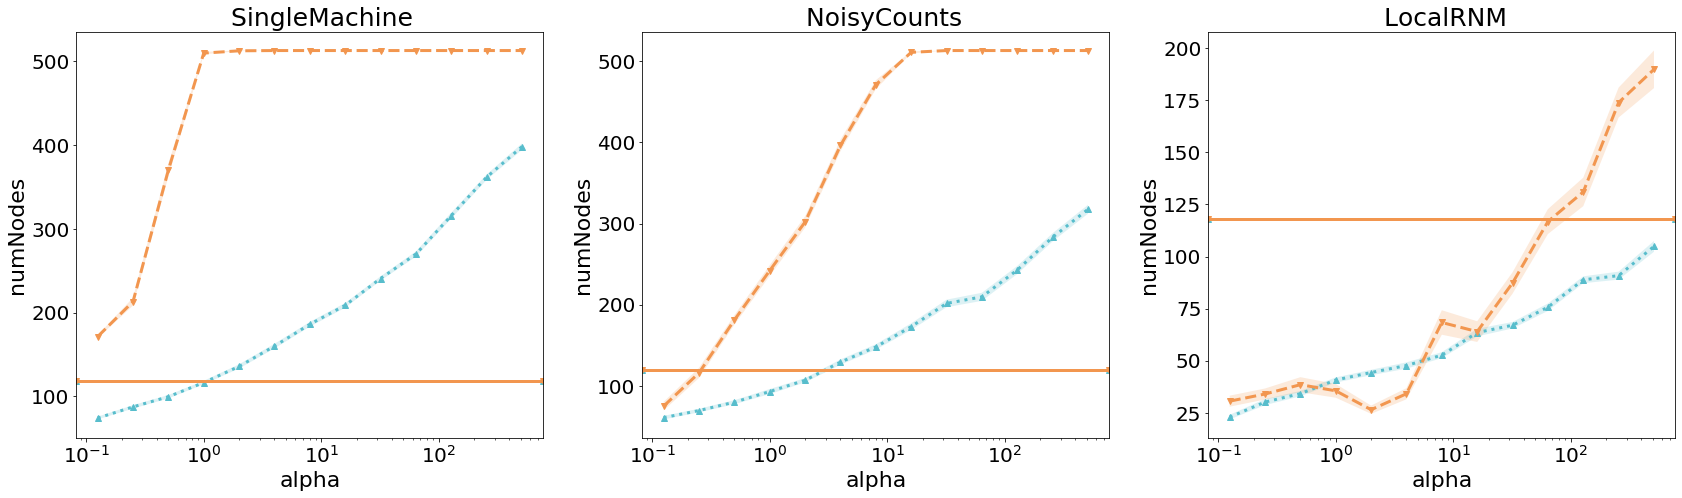

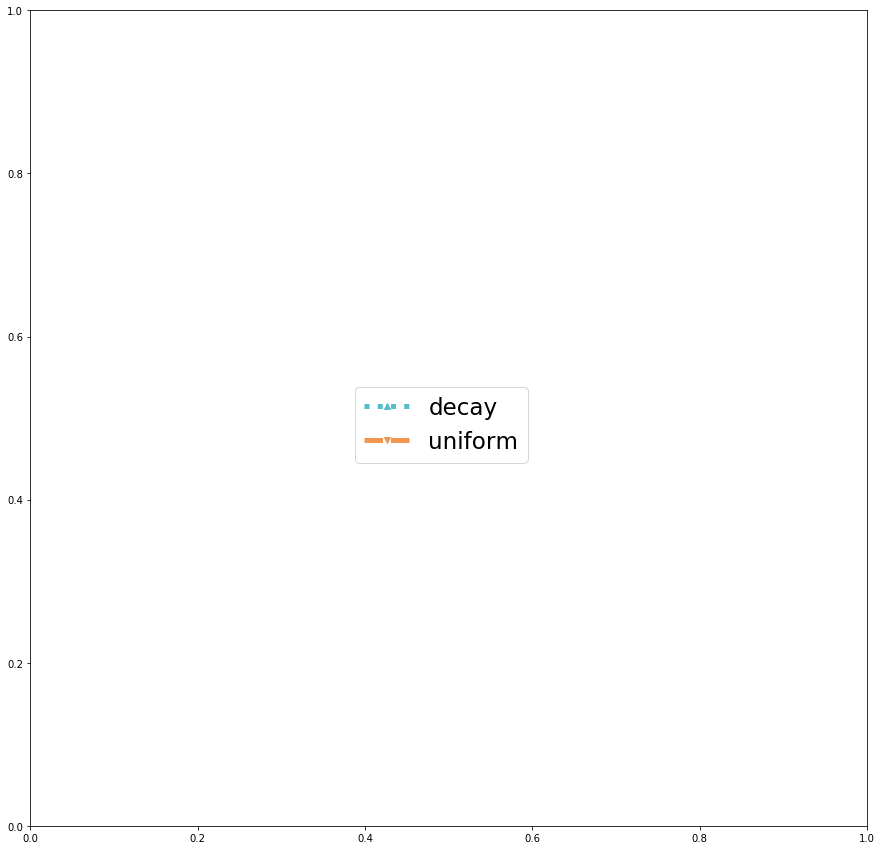

In [616]:
for dataset in ['adult', 'bank', 'creditcard', 'skin']:
    multiplot(3, df, fixed_axises={'trainingFraction': 1, 'leafPrivacyFraction': 0.5, 'dataset': dataset},
             subplot_axis='algo', xaxis='alpha', yaxis='numNodes',
             zaxises=['budgetFn'], use_color_alpha=False, plot_legend=(dataset == 'skin'))

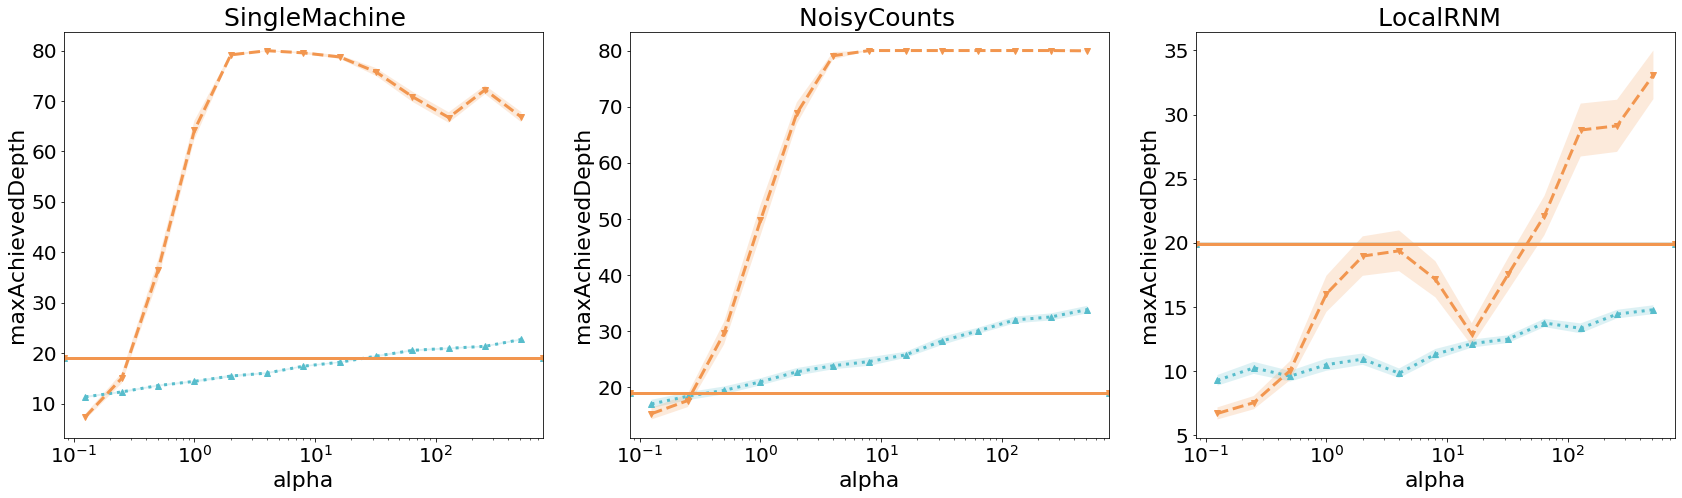

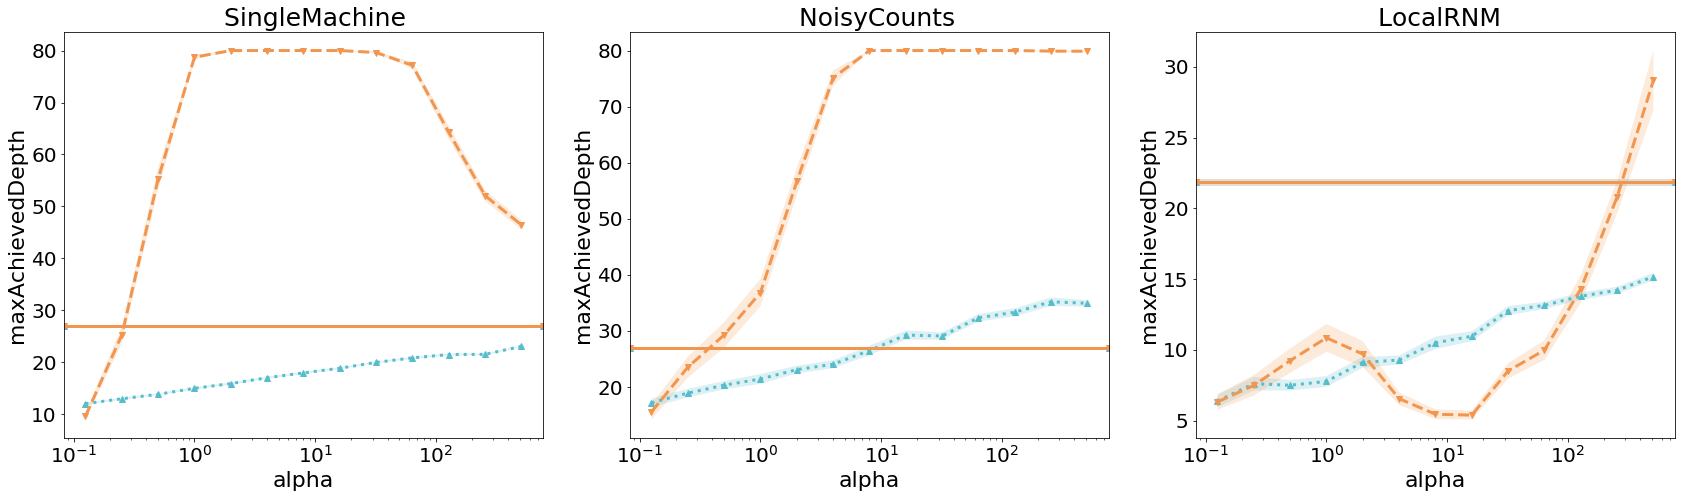

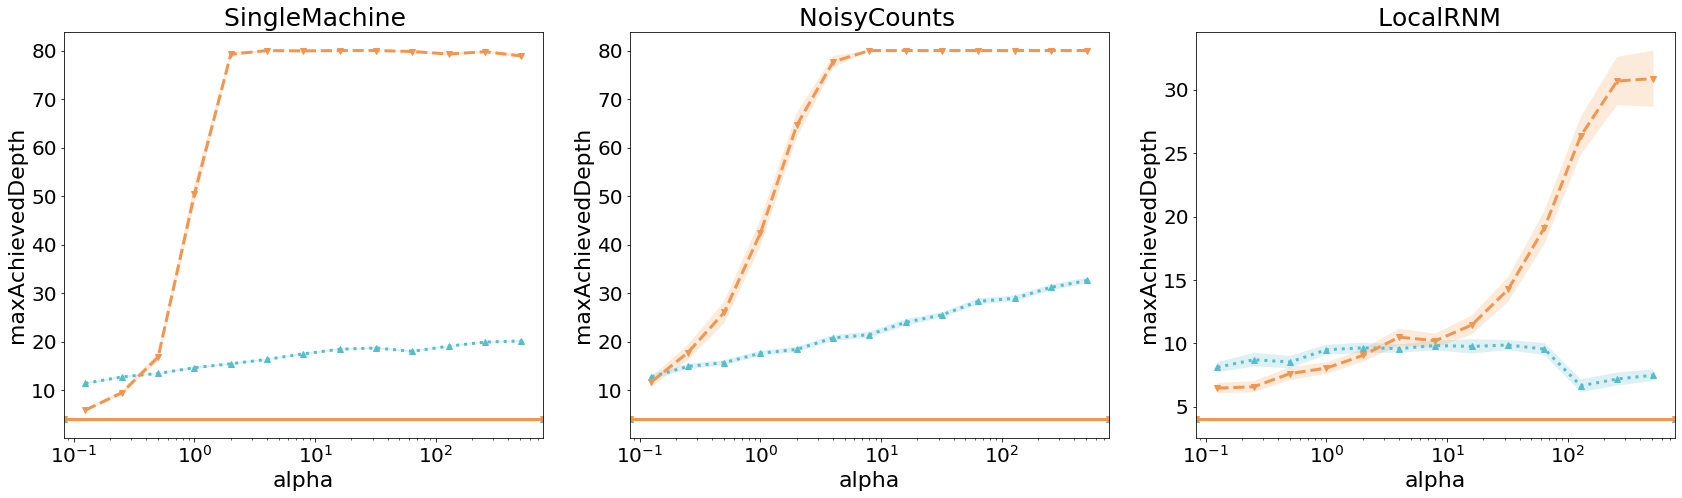

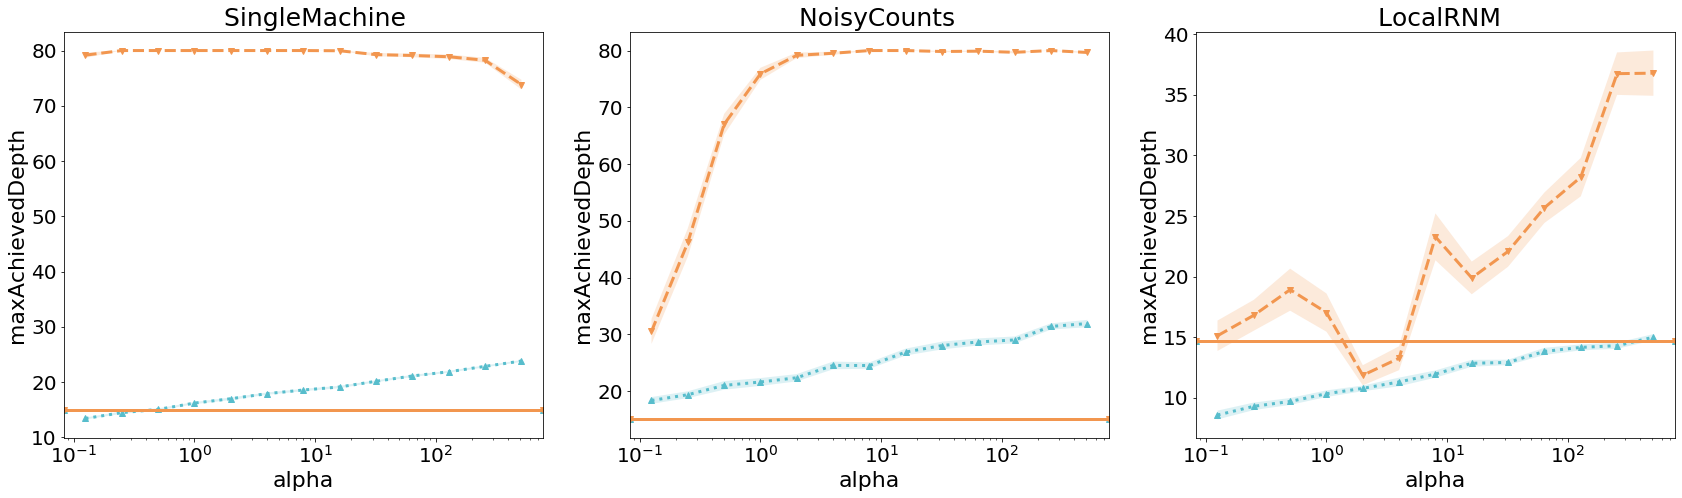

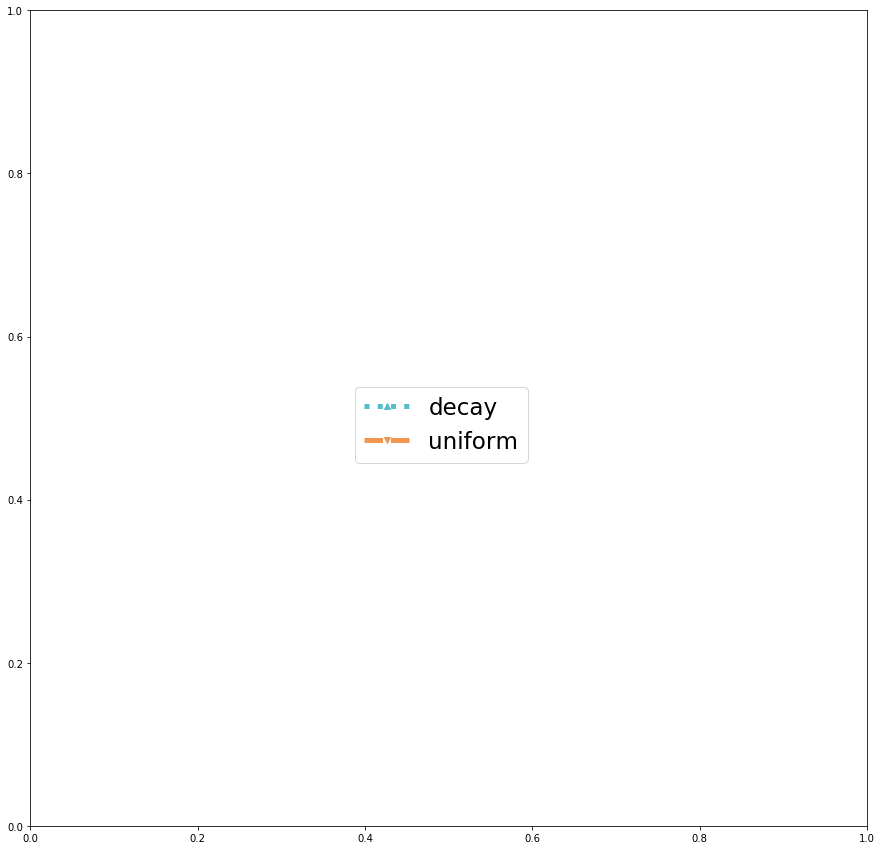

In [615]:
for dataset in ['adult', 'bank', 'creditcard', 'skin']:
    multiplot(3, df, fixed_axises={'trainingFraction': 1, 'leafPrivacyFraction': 0.5, 'dataset': dataset},
             subplot_axis='algo', xaxis='alpha', yaxis='maxAchievedDepth',
             zaxises=['budgetFn'], use_color_alpha=False, plot_legend=(dataset == 'skin'))

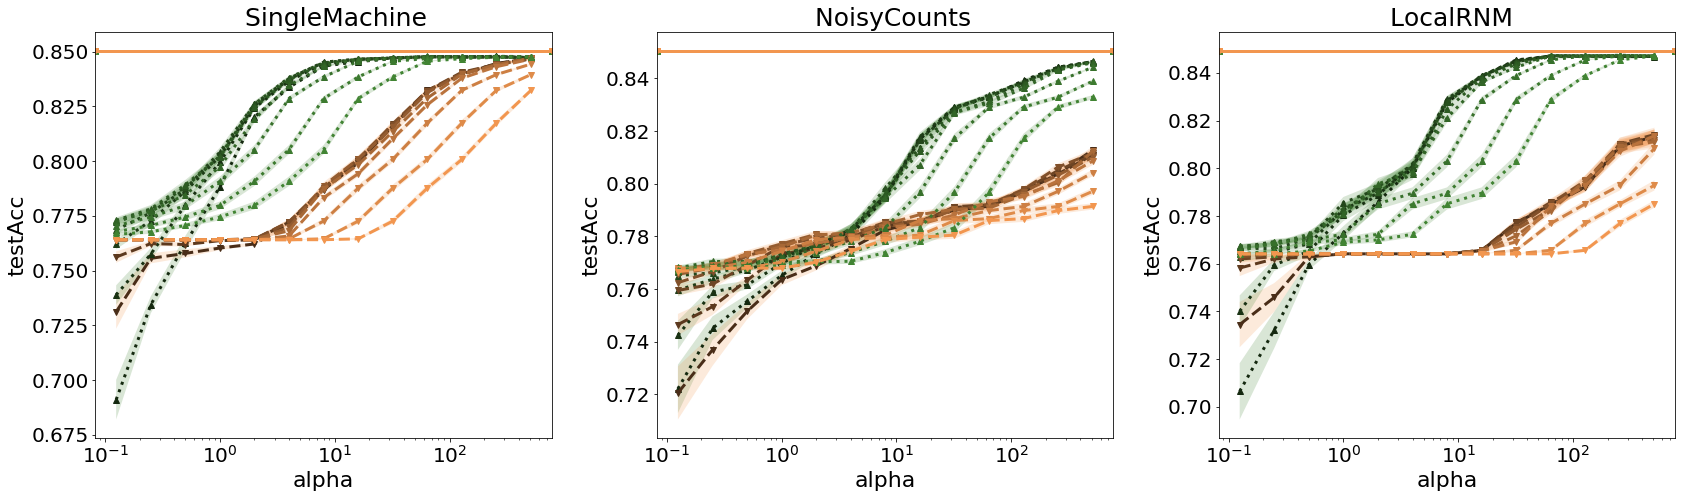

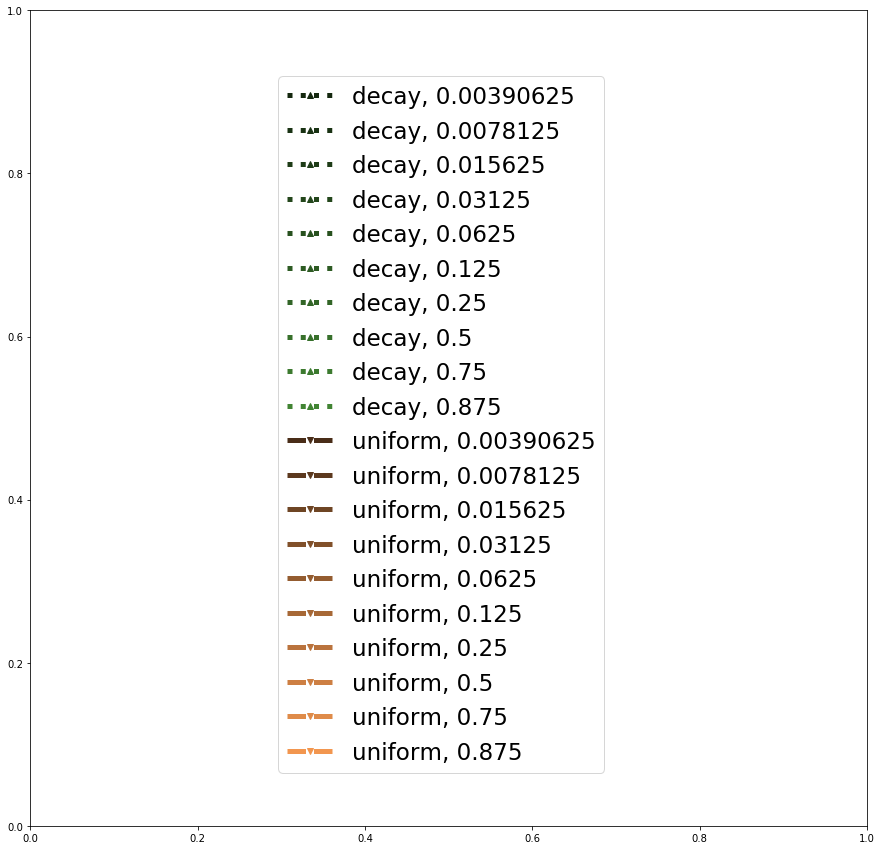

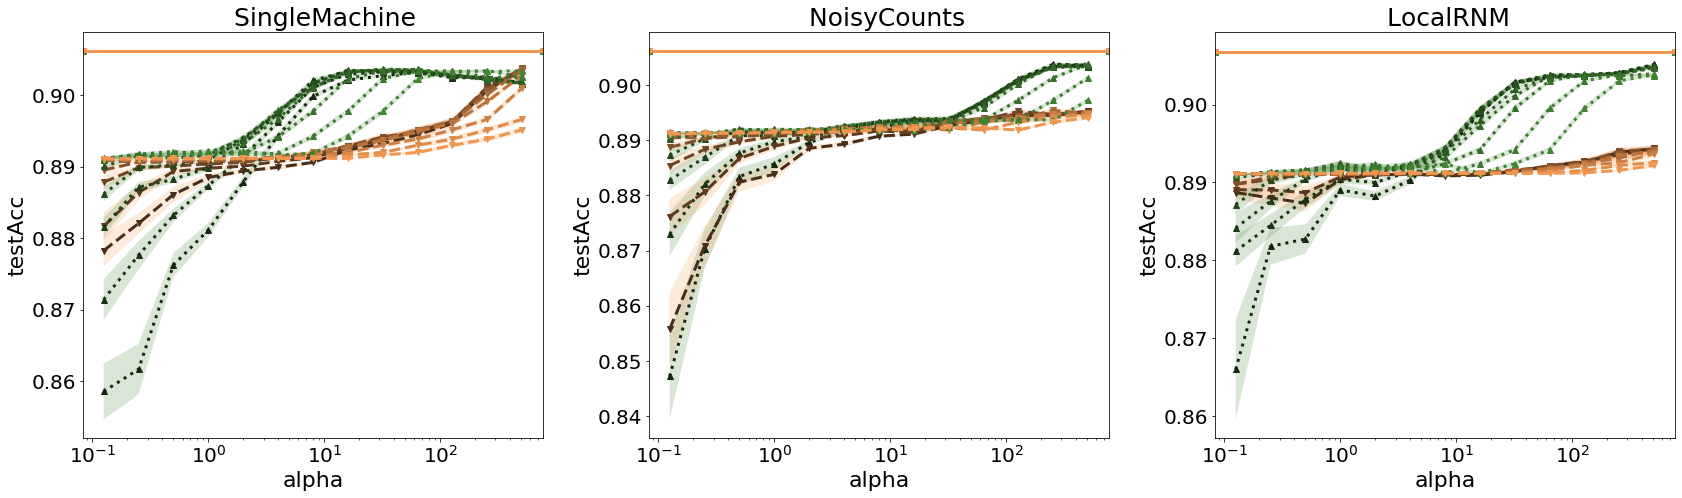

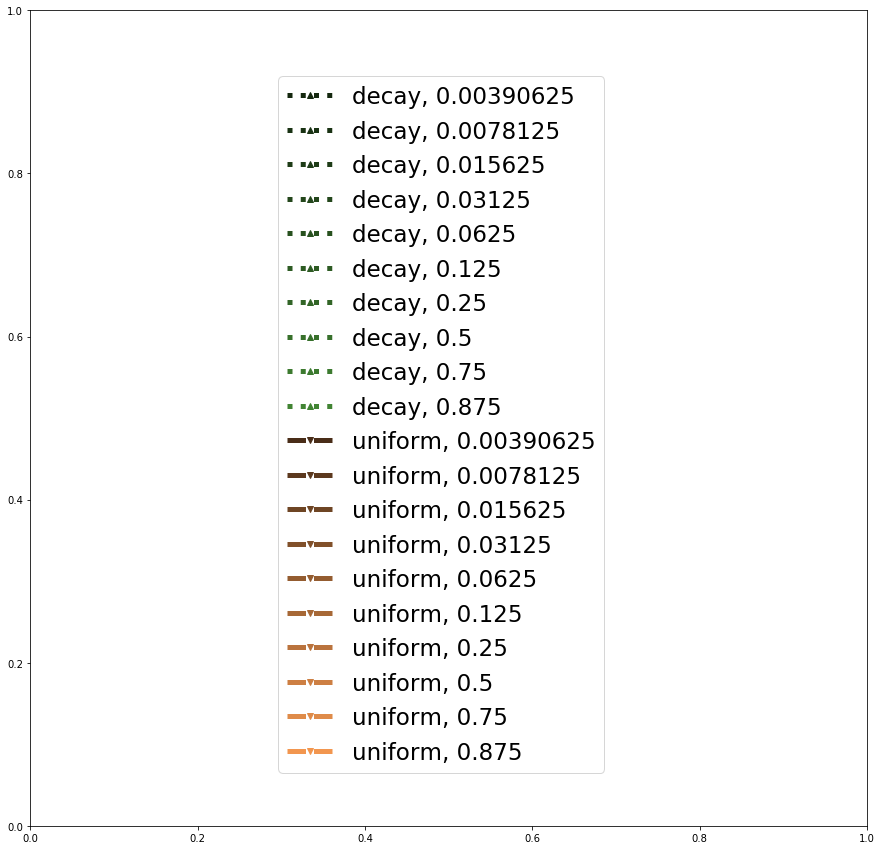

In [561]:
# For Figure 1
for dataset in ['adult', 'bank']:
    fig = multiplot(3, df, fixed_axises={'trainingFraction': 1, 'dataset': dataset}, 
                subplot_axis='algo', xaxis='alpha', yaxis='testAcc',
                zaxises=['leafPrivacyFraction', 'budgetFn'], use_color_alpha=True)

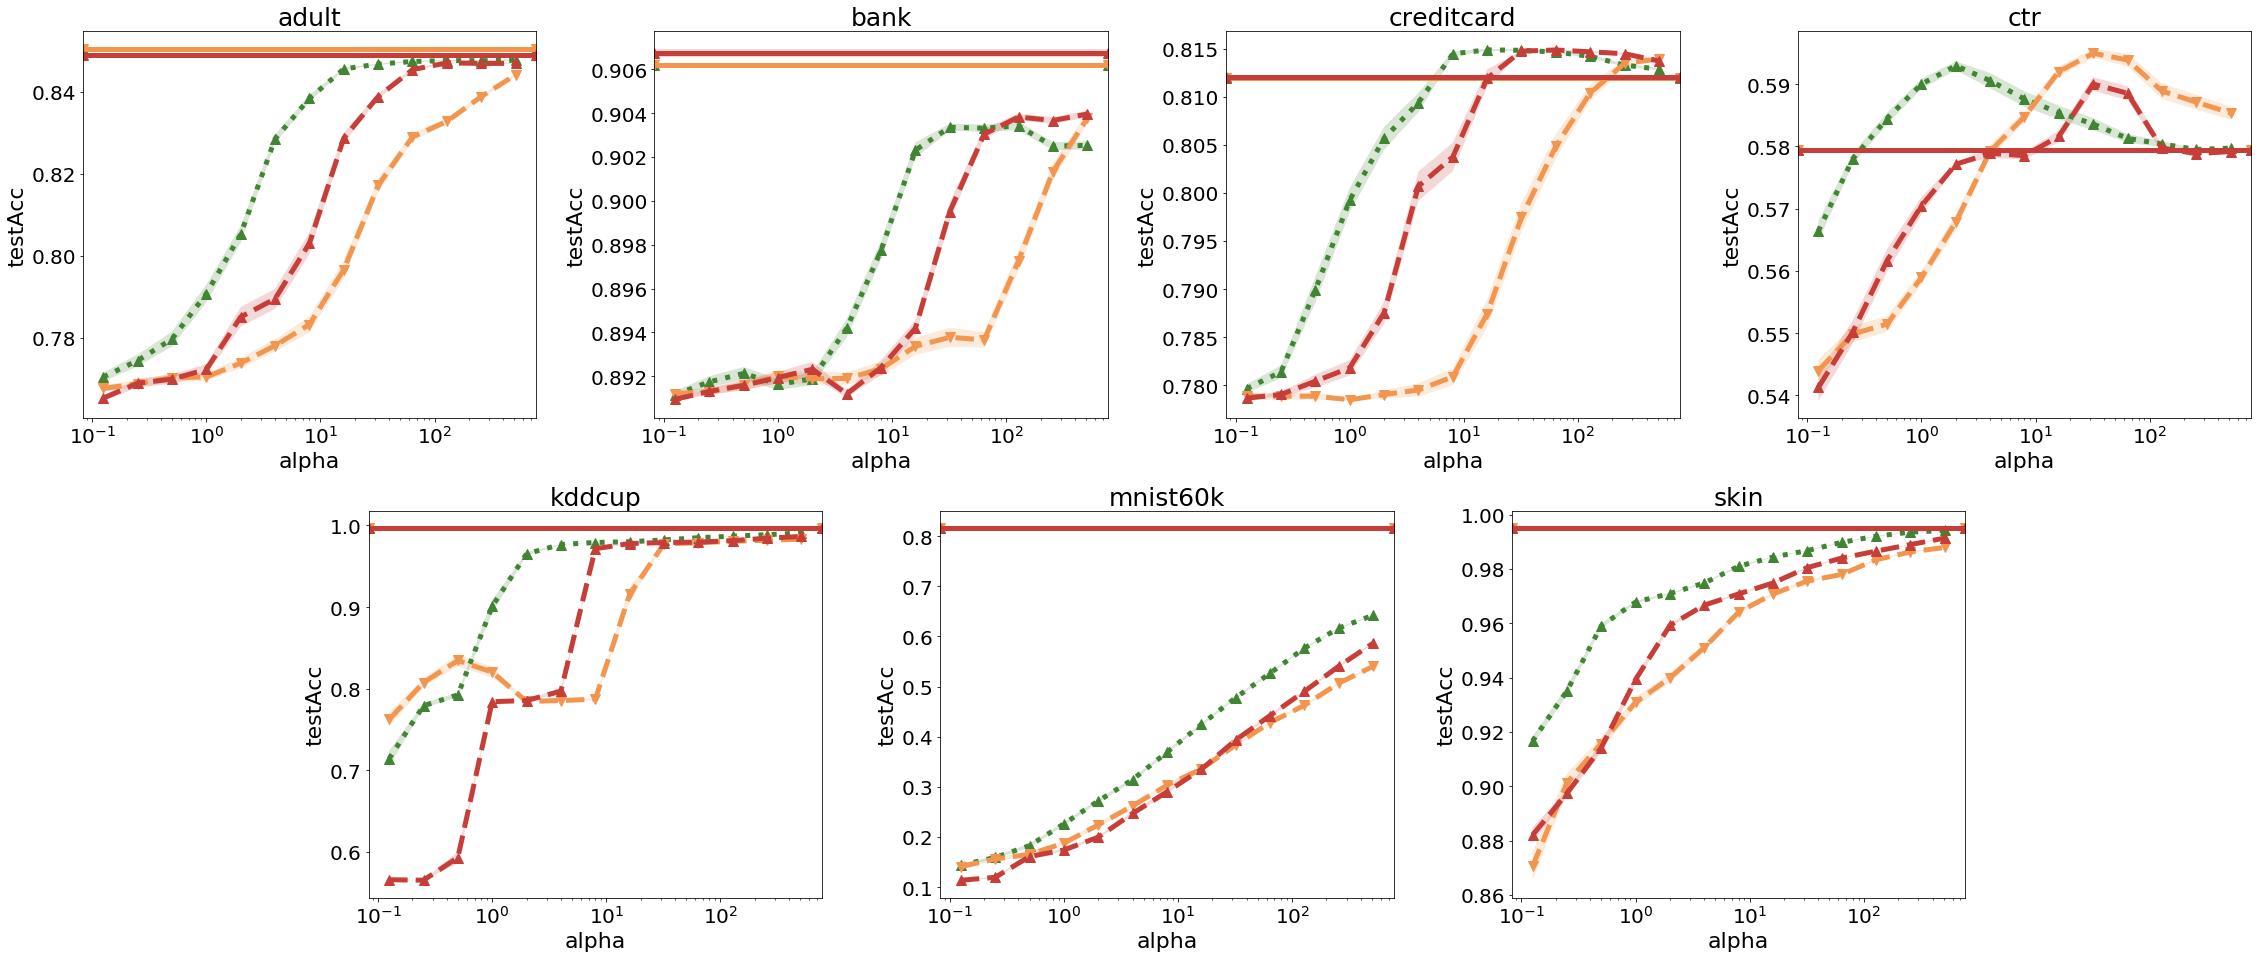

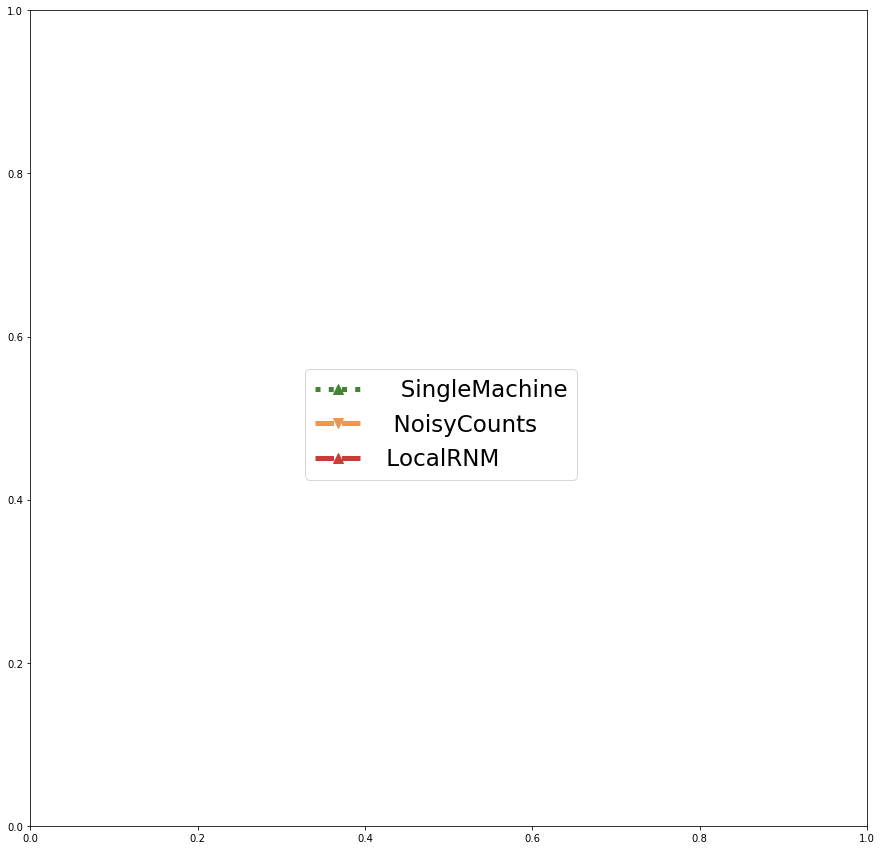

In [20]:
# For Figure 2
fig = multiplot(4, df, fixed_axises={'trainingFraction': 1, 'leafPrivacyFraction': 0.5, 'budgetFn': 'decay'}, 
      subplot_axis='dataset', xaxis='alpha', yaxis='testAcc', zaxises=['algo'], use_color_alpha=False, plot_legend=True)

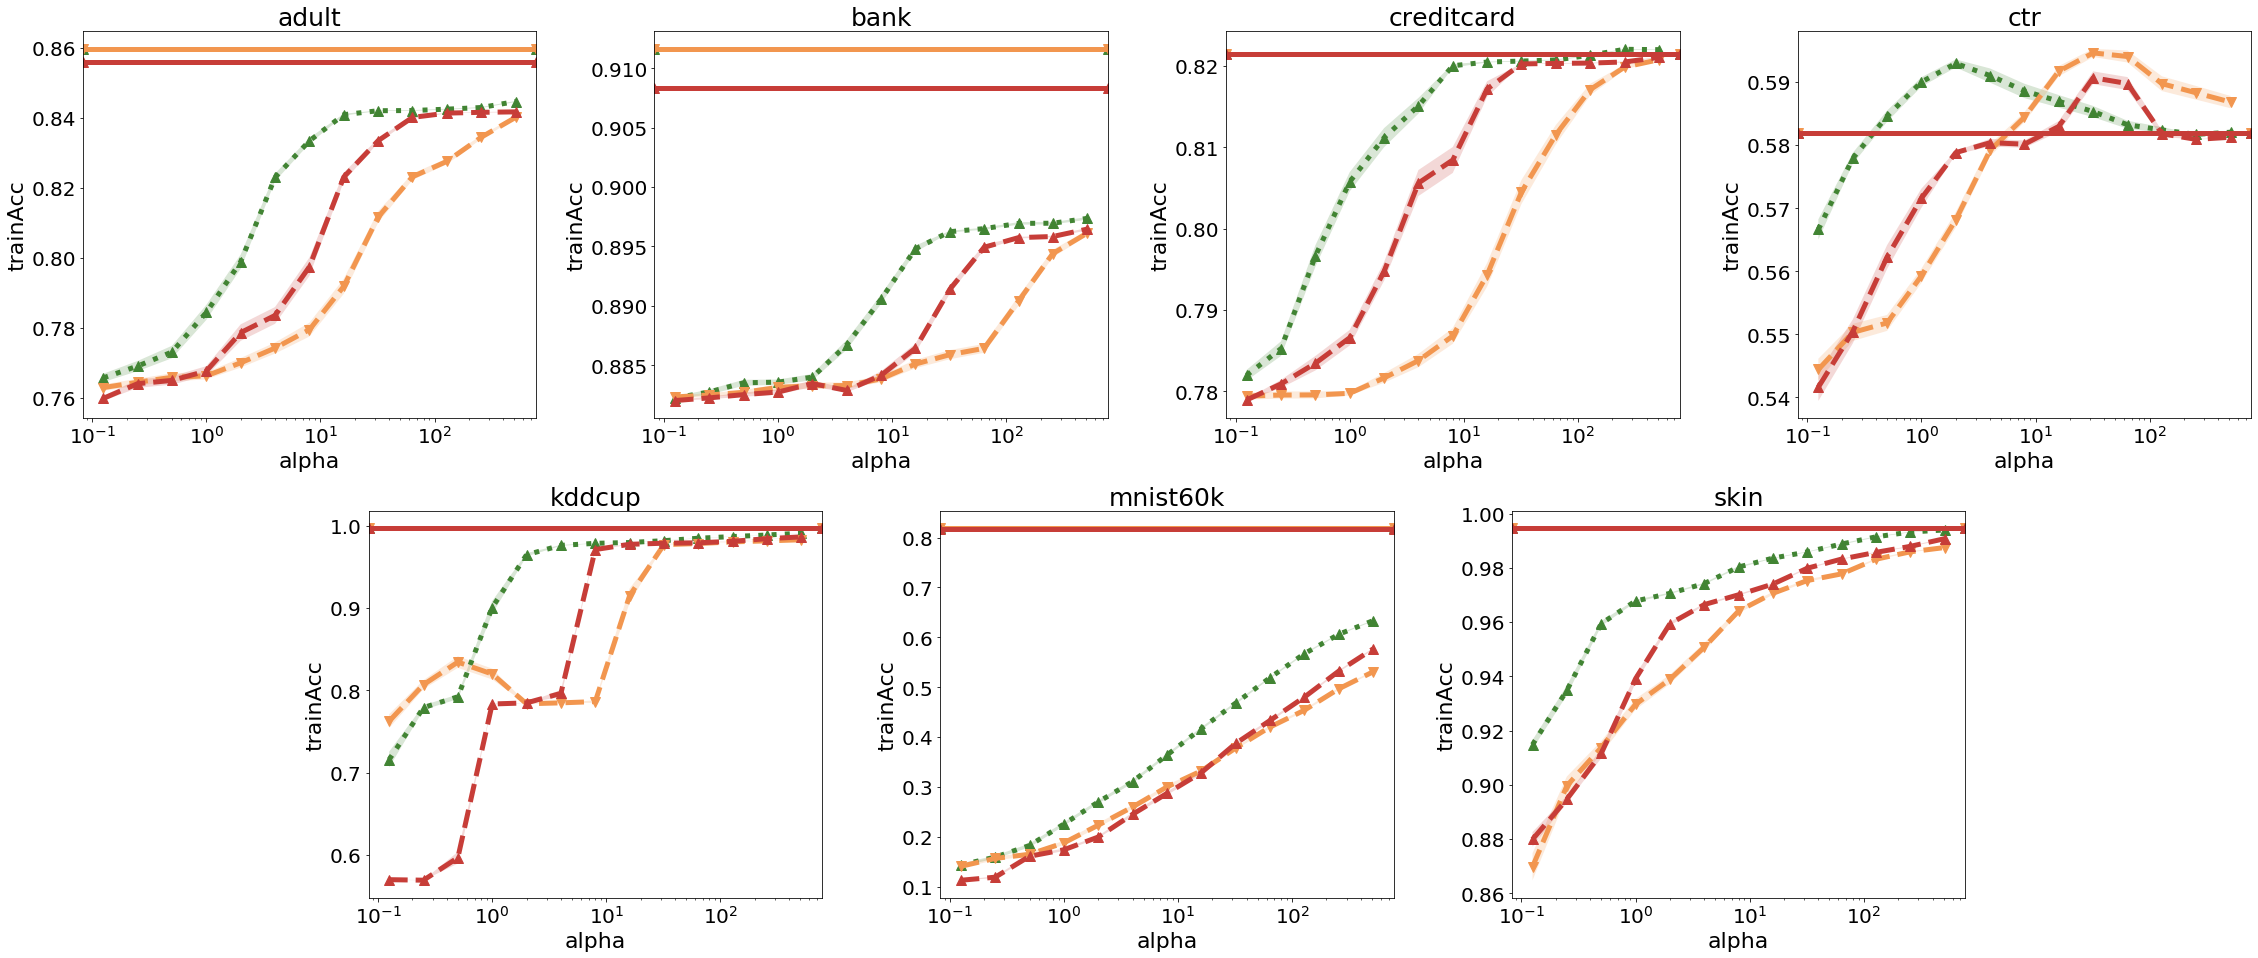

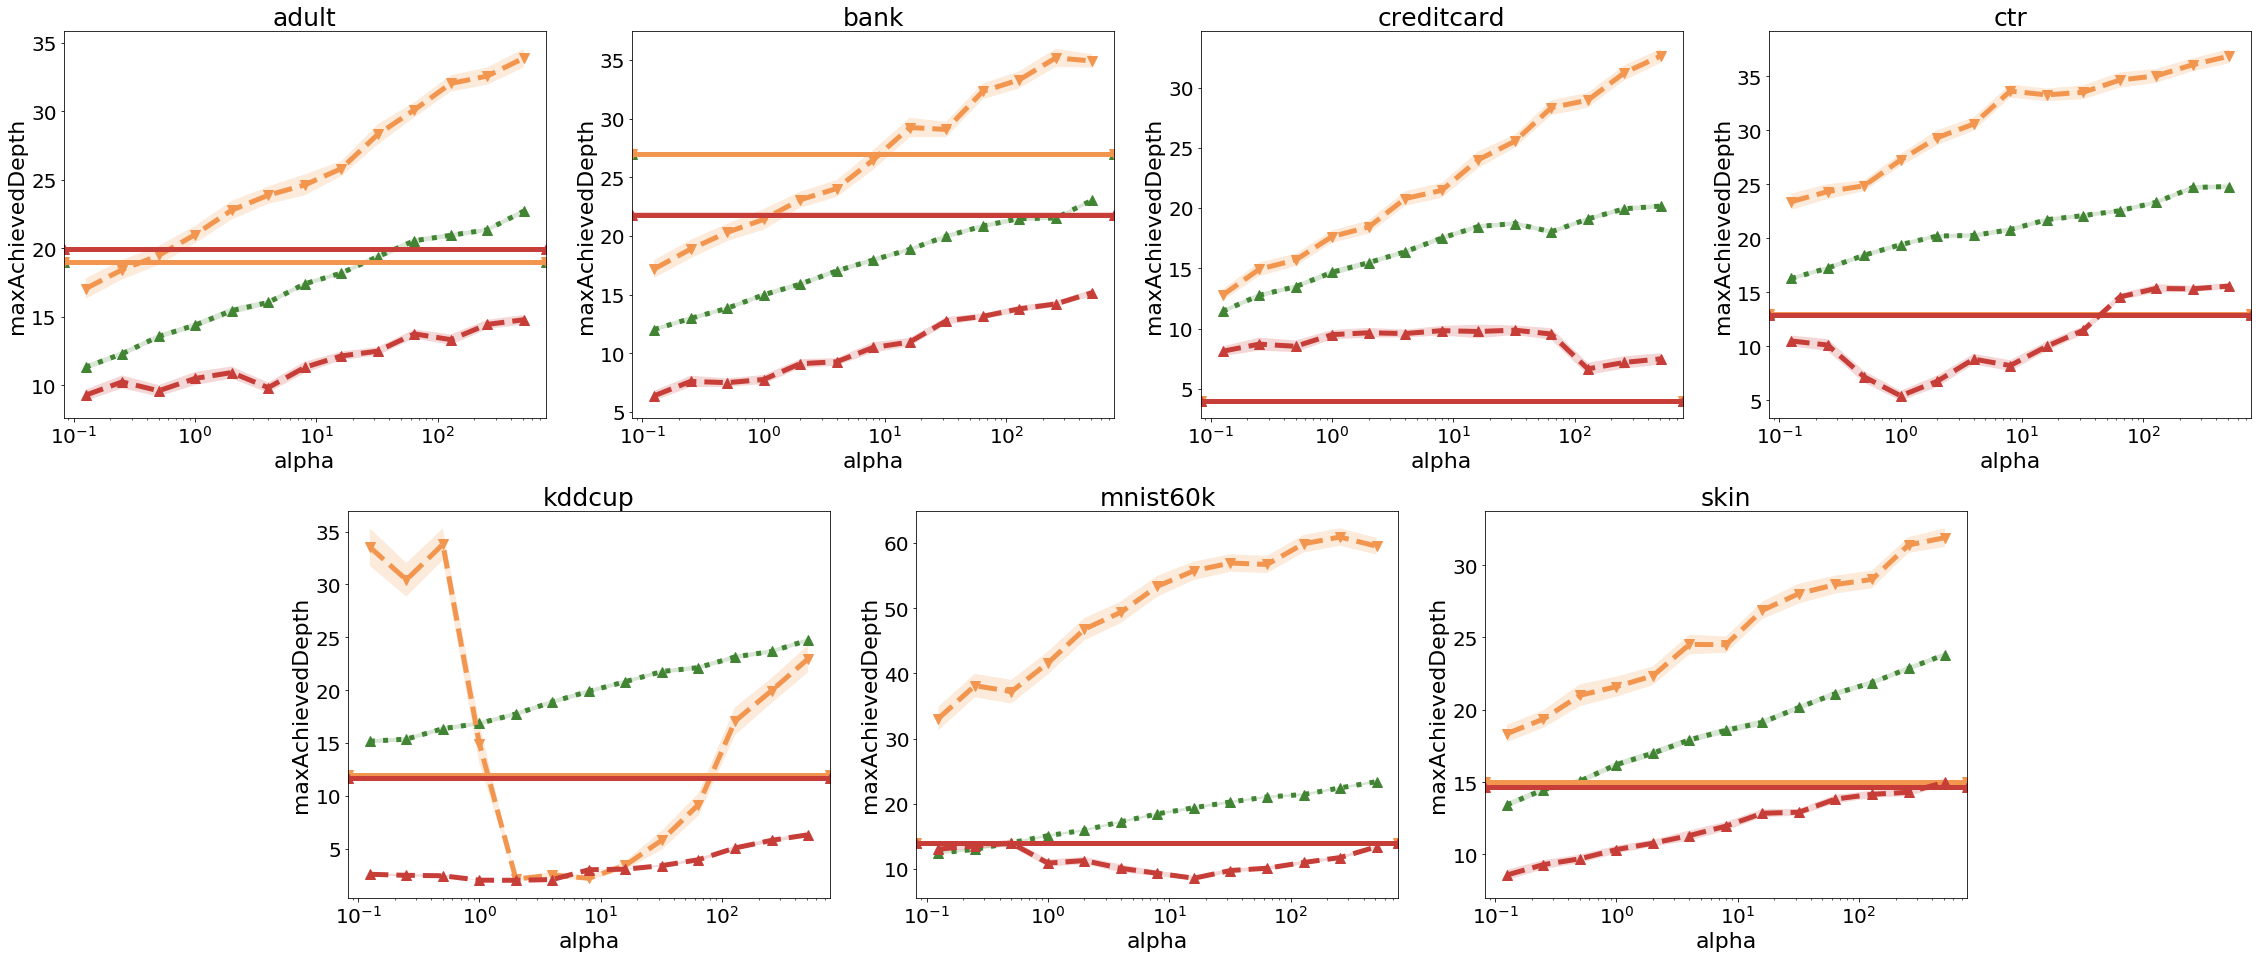

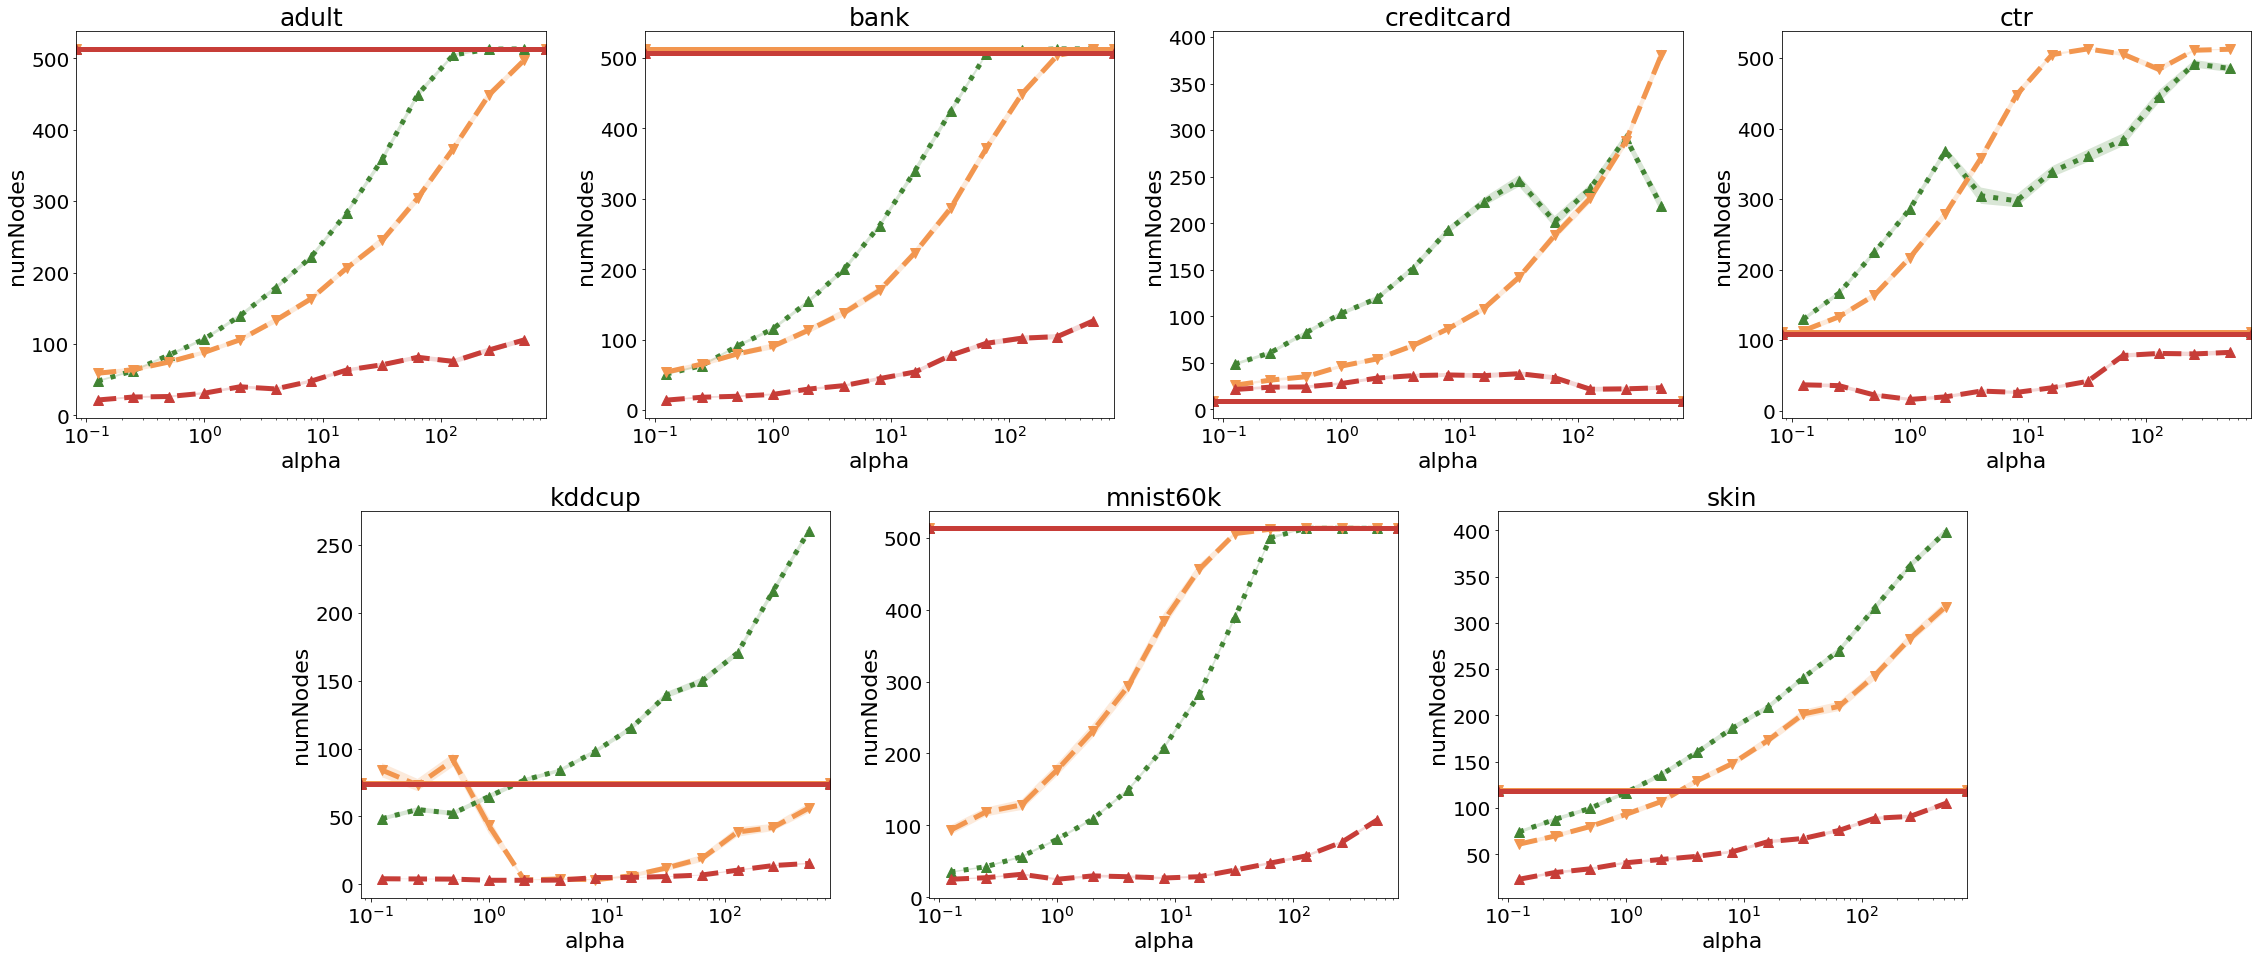

In [21]:
# For Appendix figure similar to Figure 2
for yaxis in ['trainAcc', 'maxAchievedDepth', 'numNodes']:
    fig = multiplot(4, df, fixed_axises={'trainingFraction': 1, 'leafPrivacyFraction': 0.5, 'budgetFn': 'decay'}, 
      subplot_axis='dataset', xaxis='alpha', yaxis=yaxis, zaxises=['algo'], use_color_alpha=False)

In [22]:

df2 = load_results("aws_results2")

   SingleMachine
  NoisyCounts
 LocalRNM


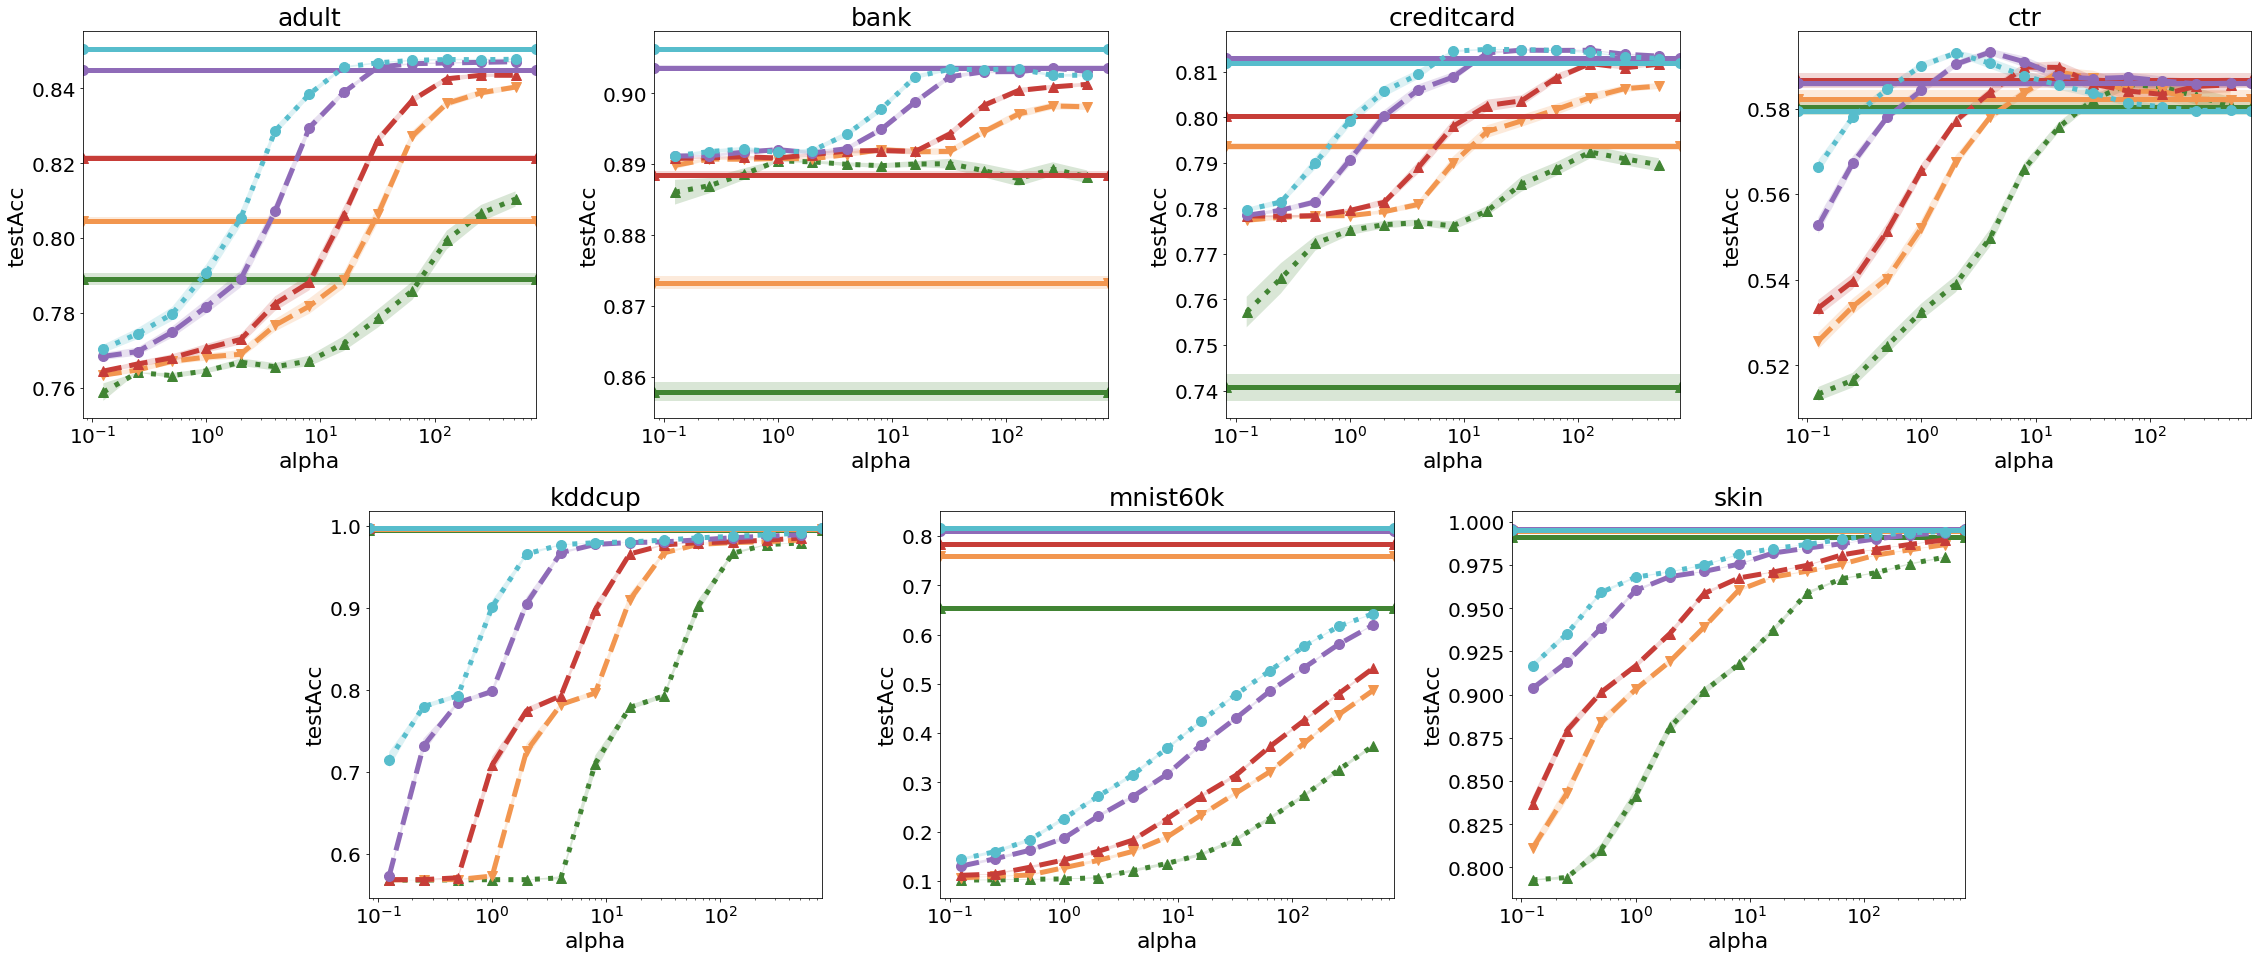

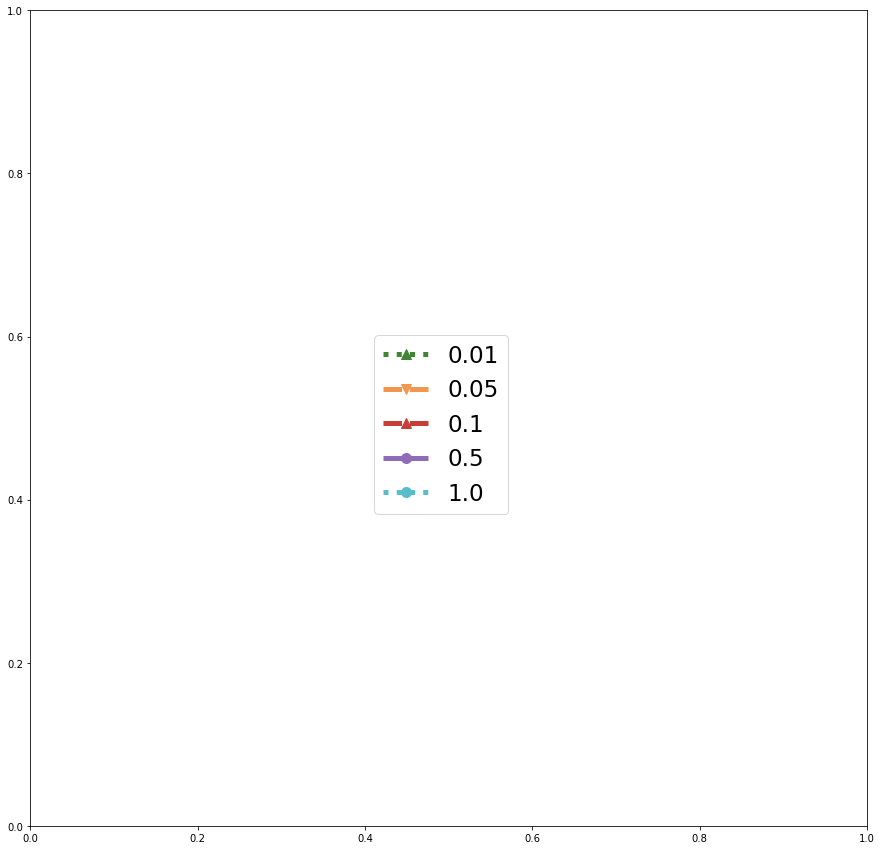

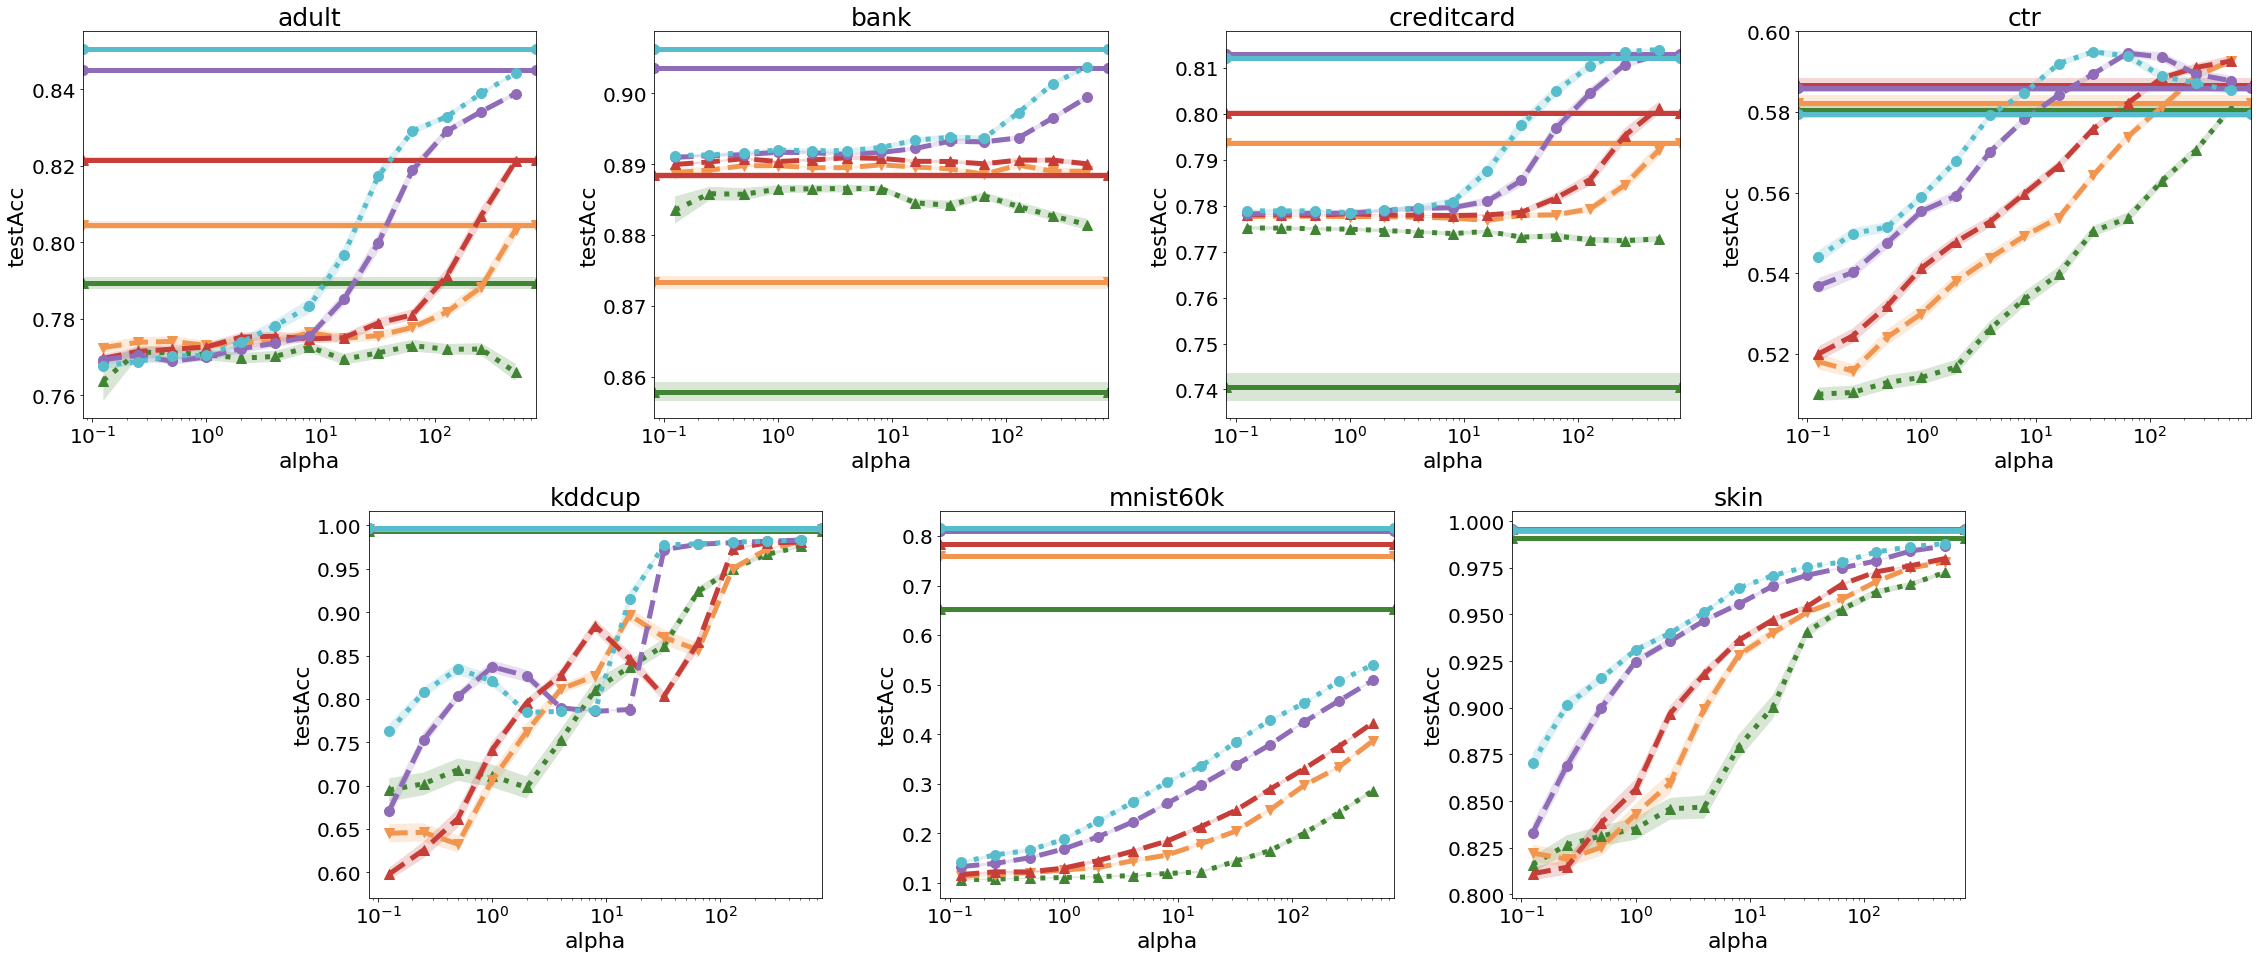

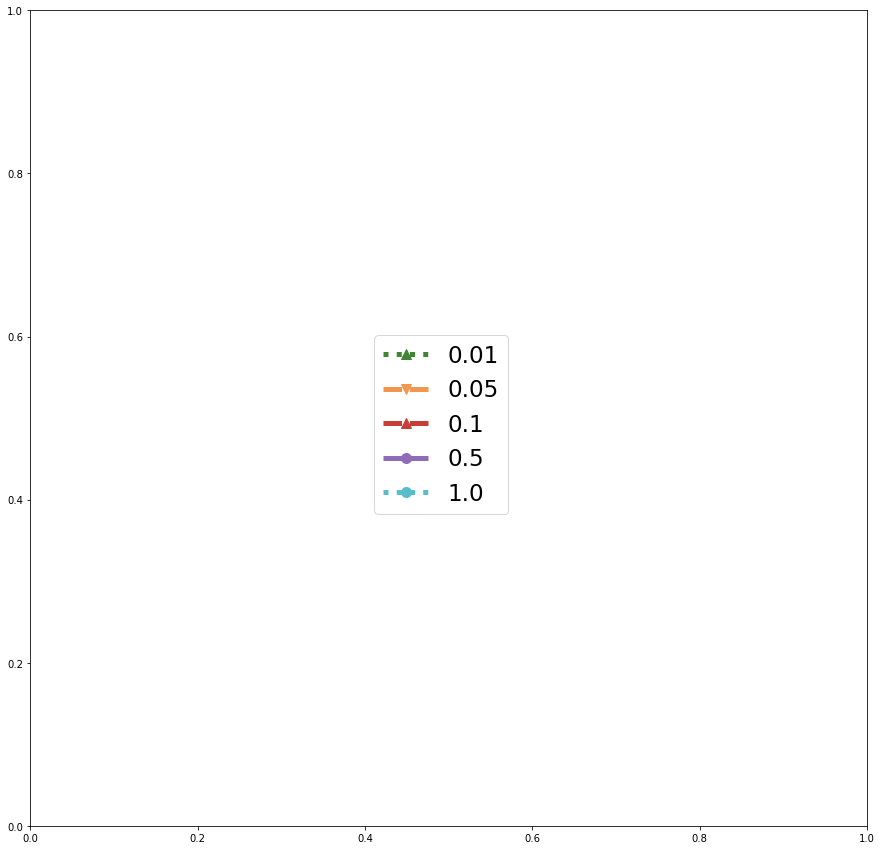

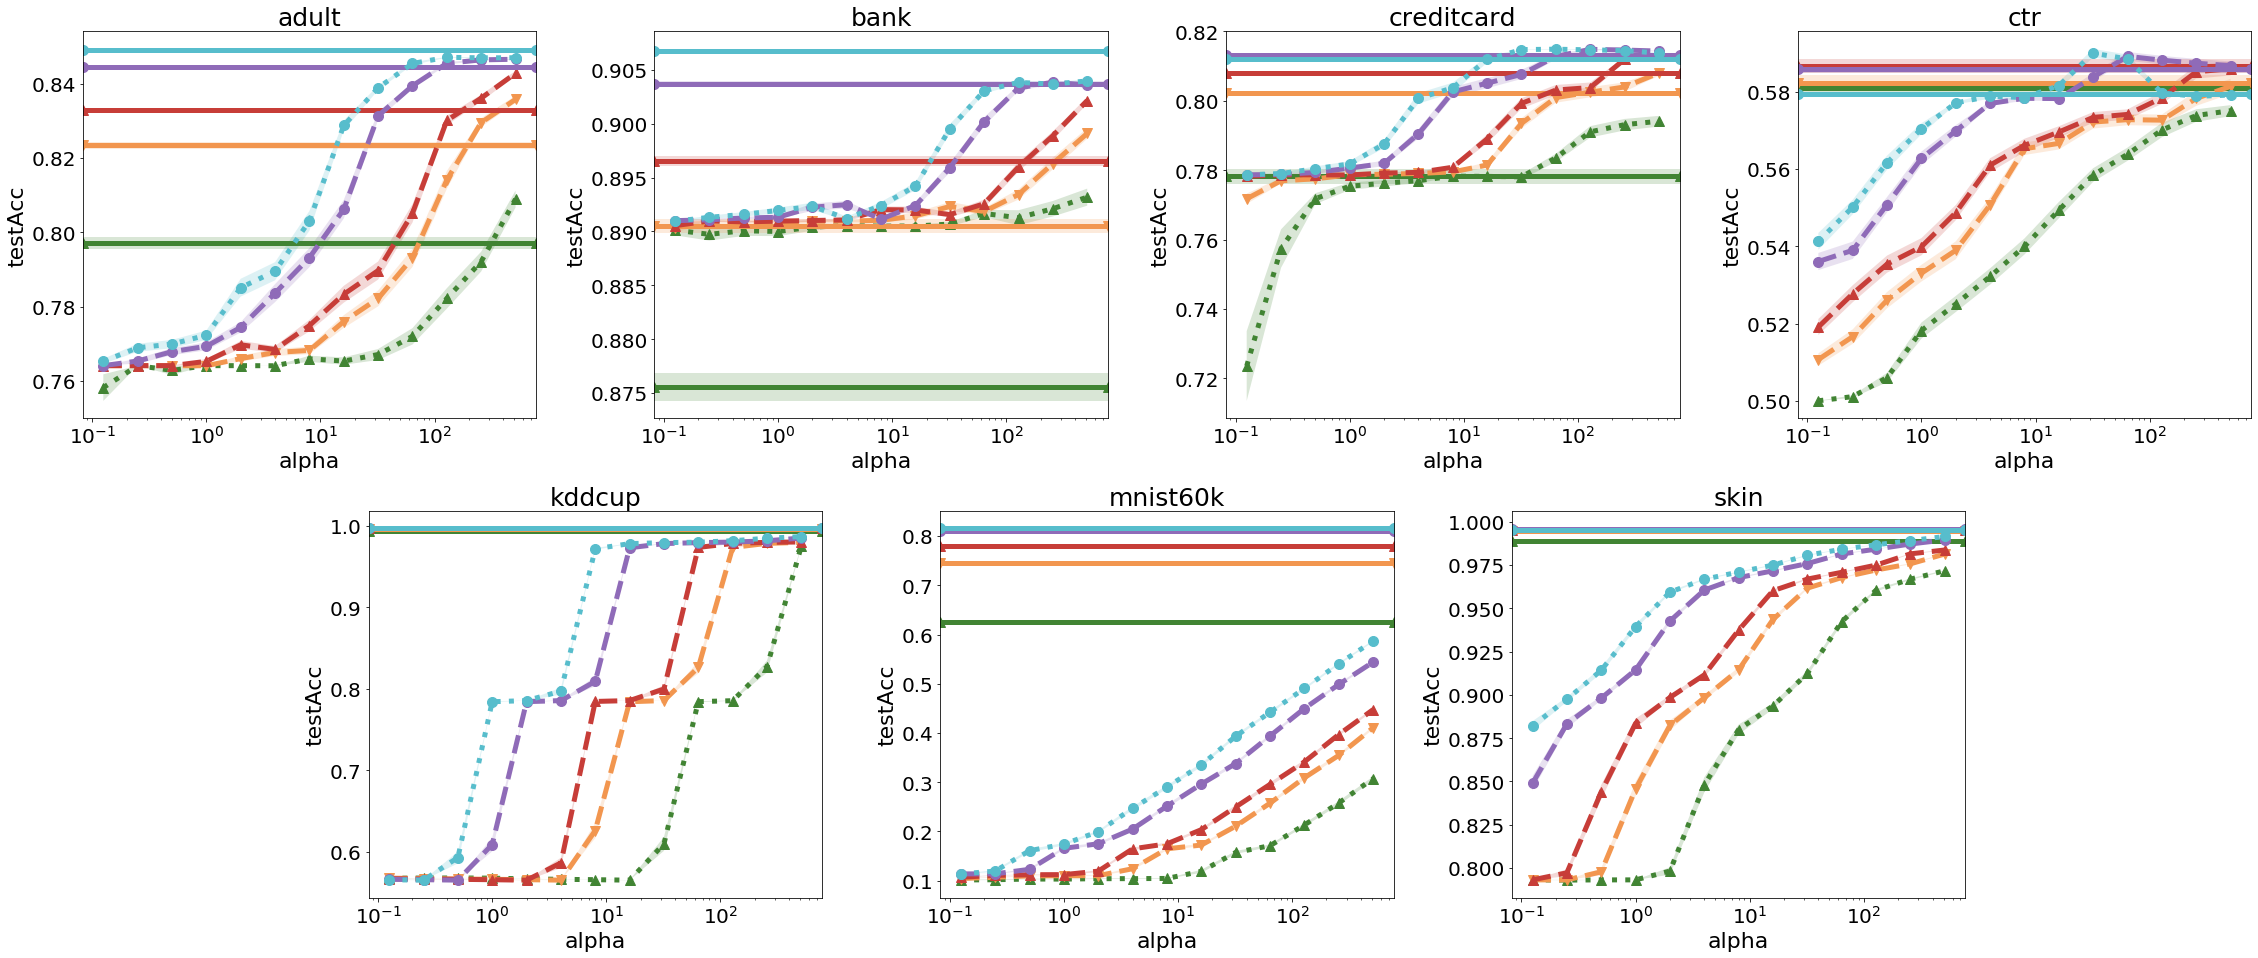

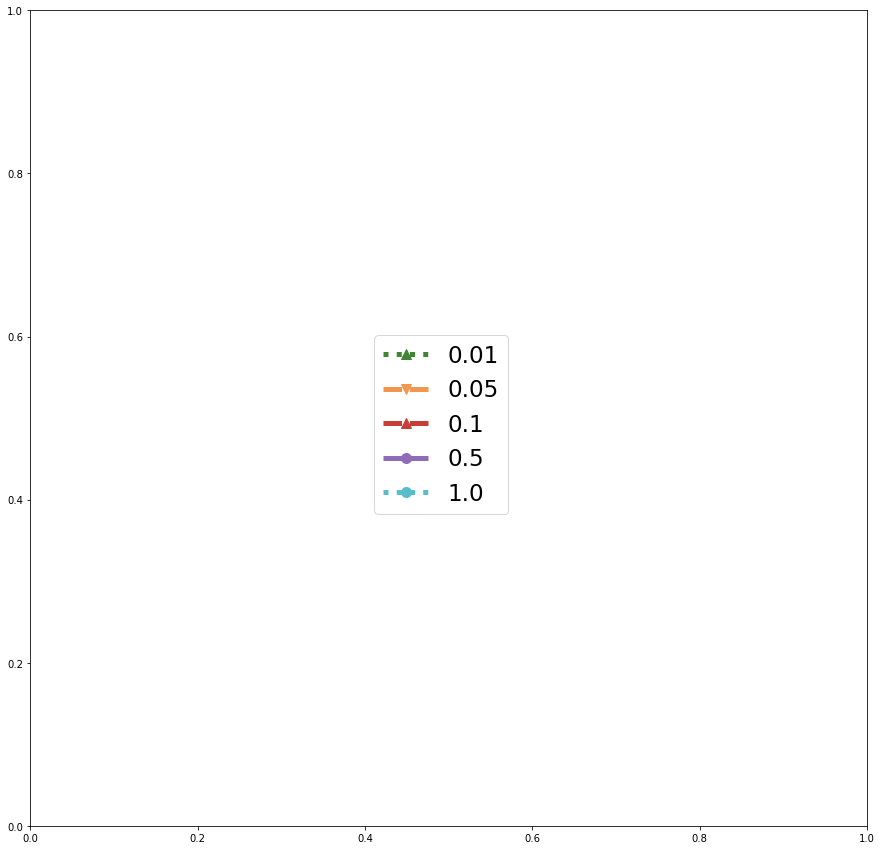

In [25]:
# For figure 3
for algo in sorted(df['algo'].unique()):
    print(algo)
    fig = multiplot(4, df2, {'algo': algo}, 
              subplot_axis='dataset', xaxis='alpha', 
              yaxis='testAcc', zaxises=['trainingFraction'], use_color_alpha=False, plot_legend=True)

   SingleMachine
  NoisyCounts
 LocalRNM


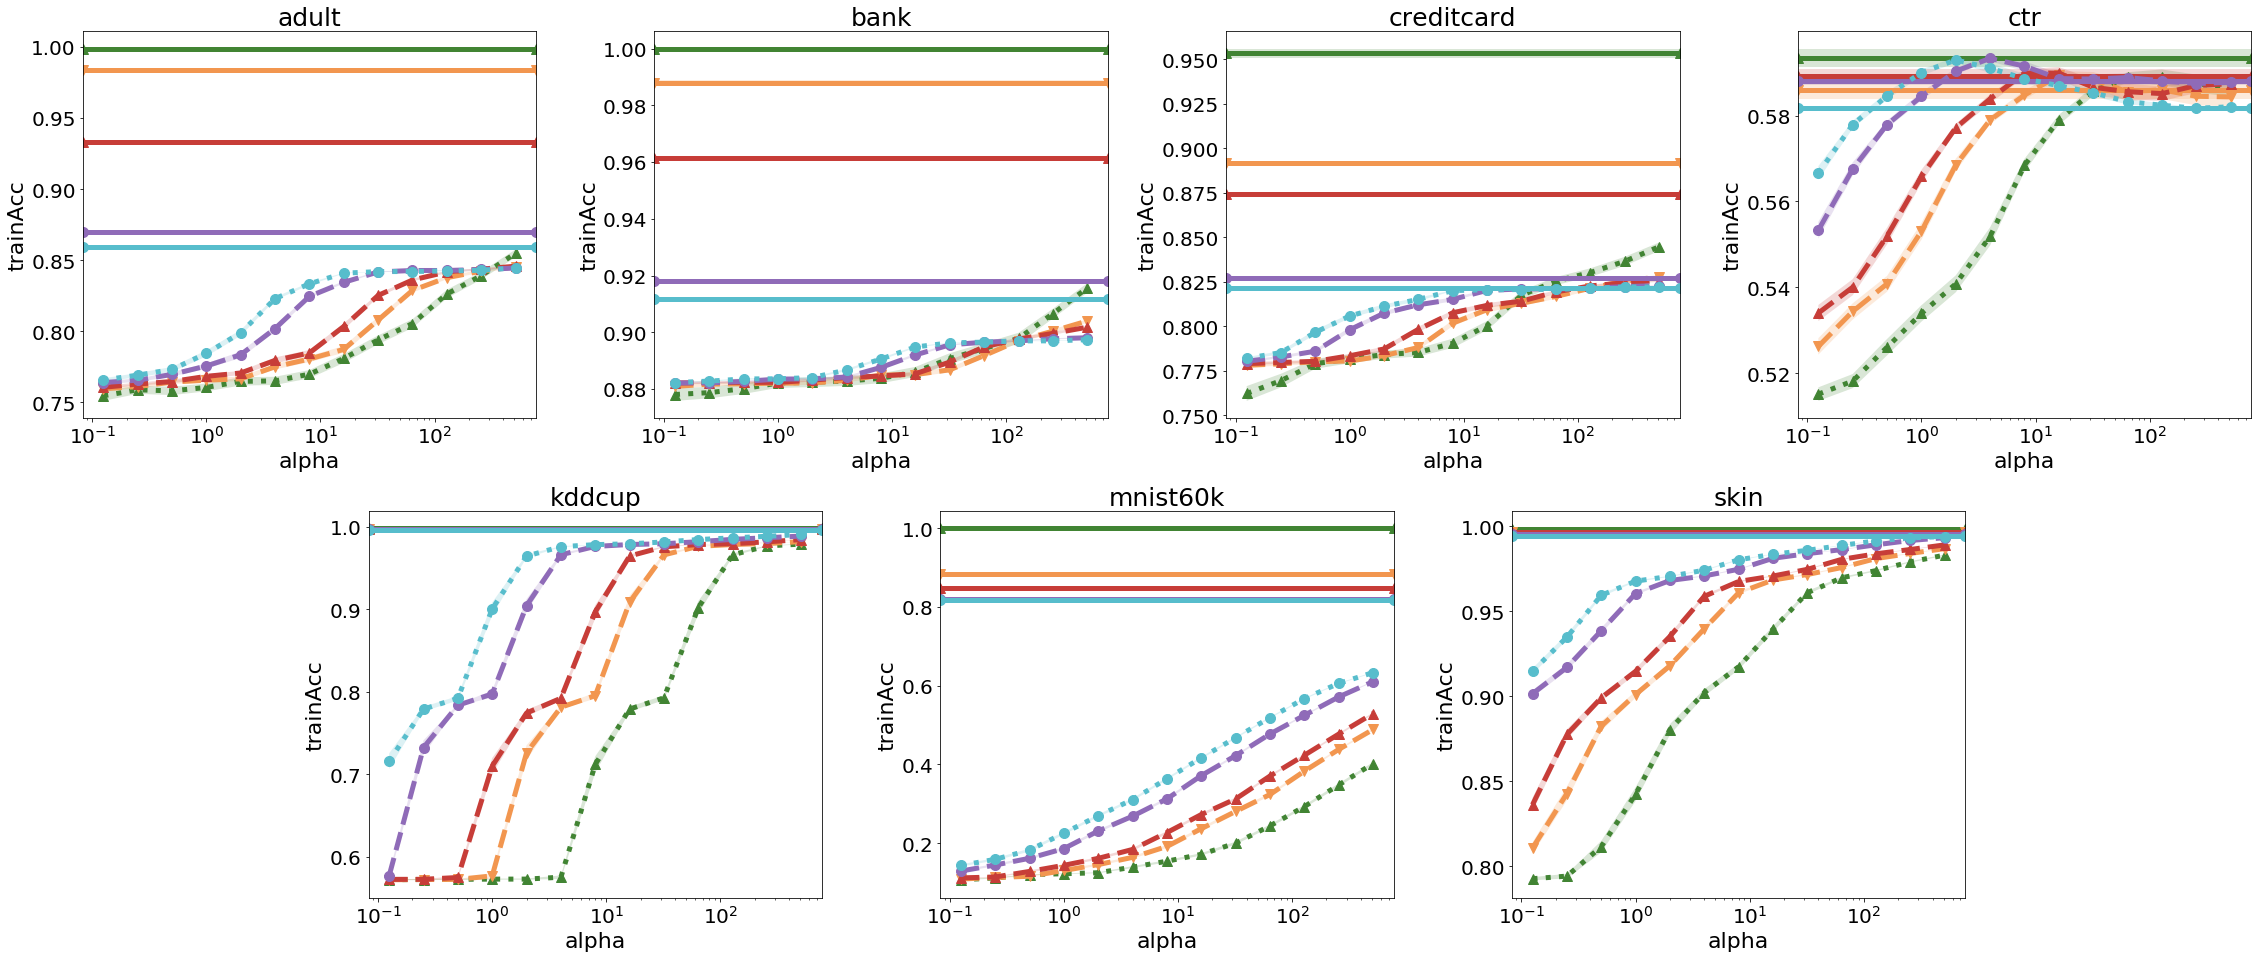

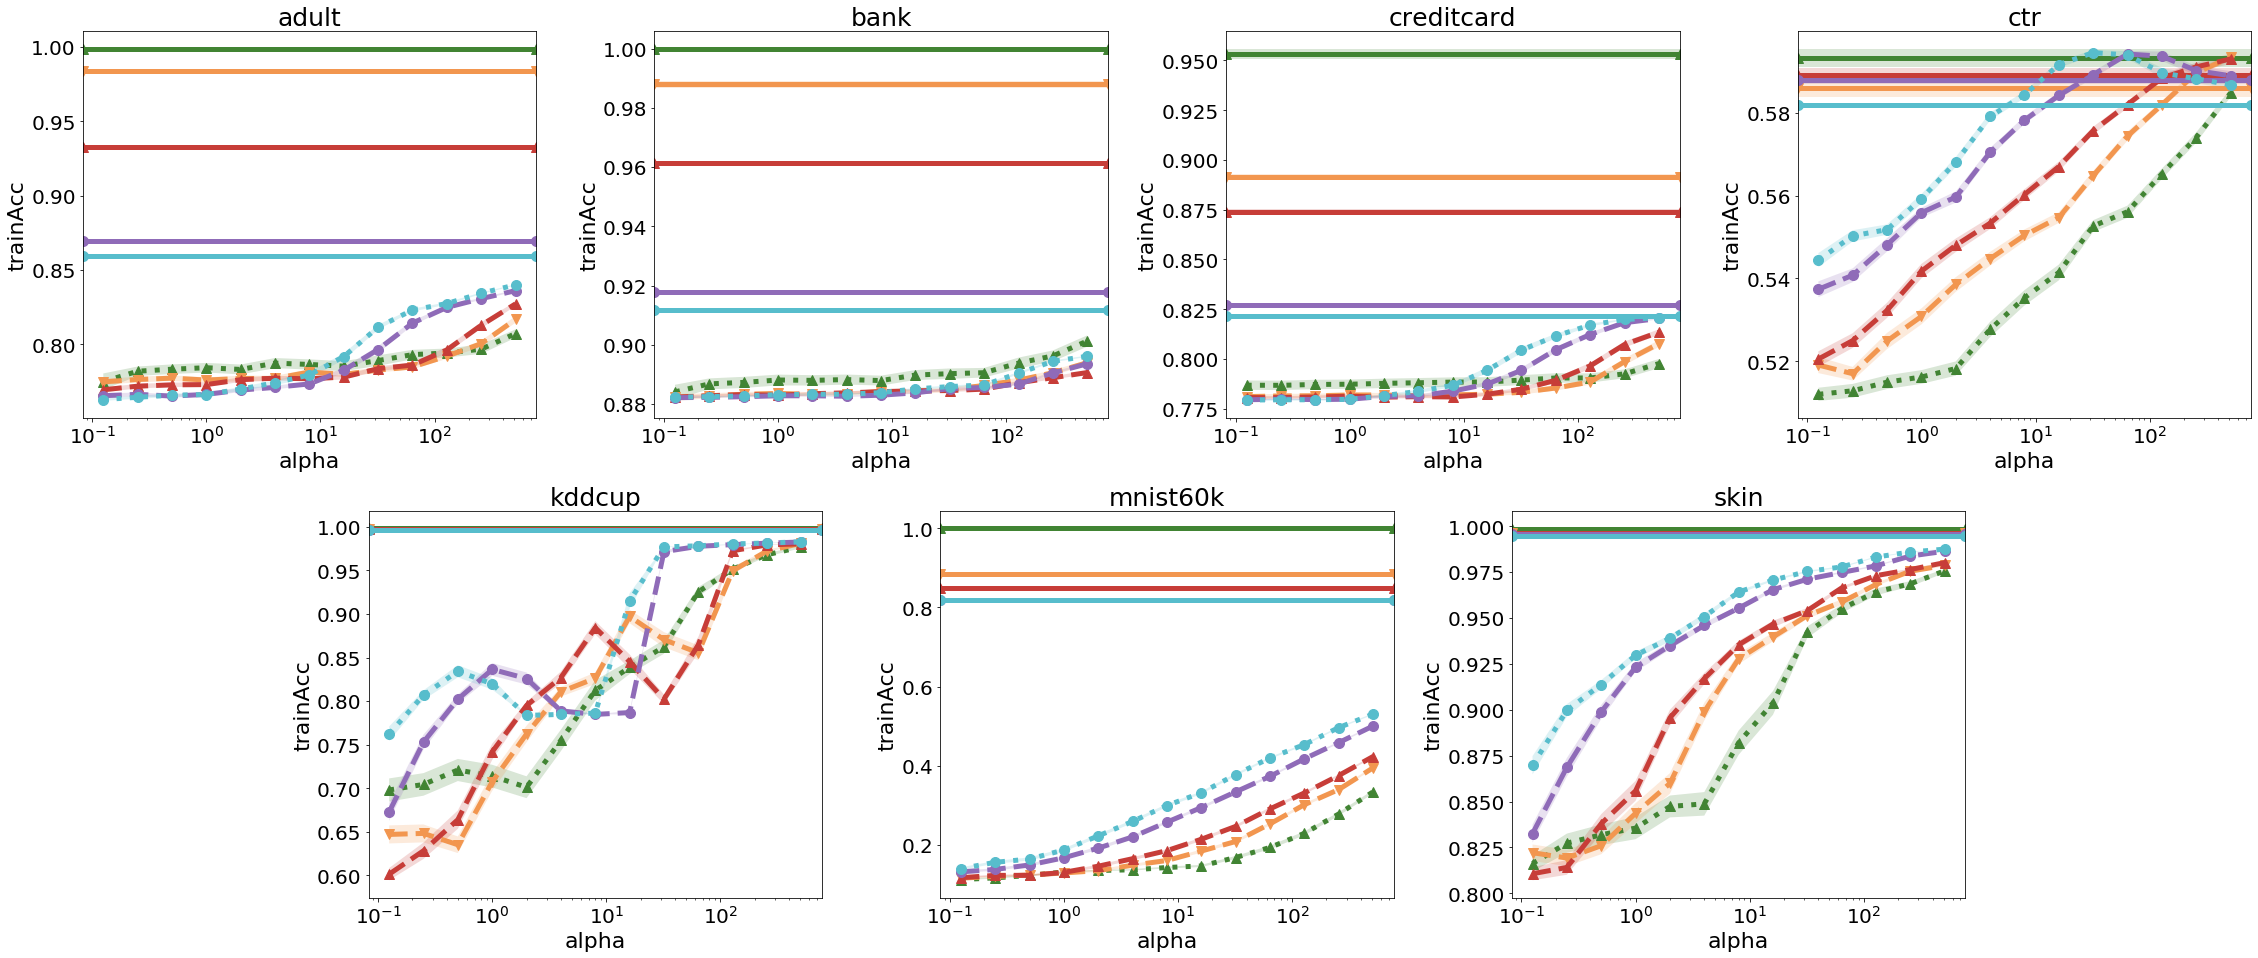

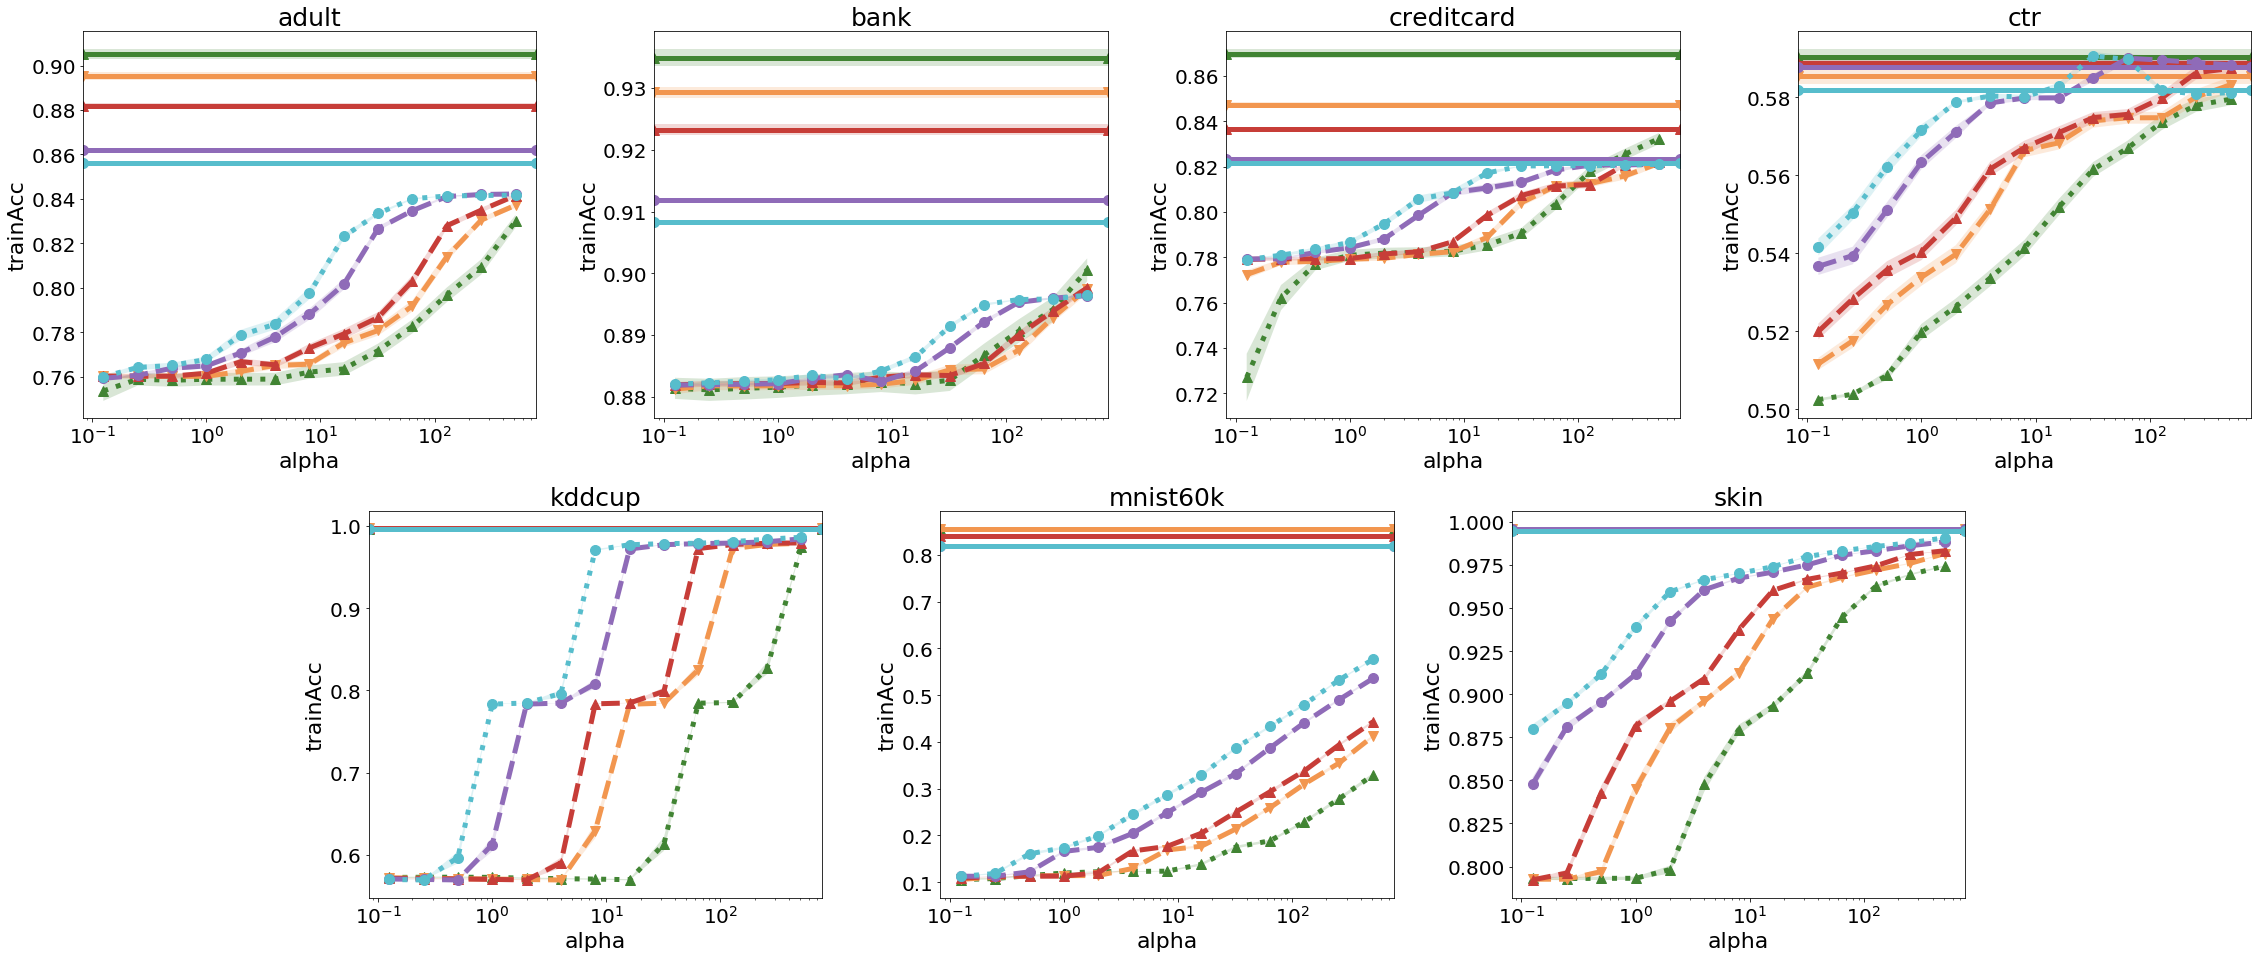

In [26]:
# For appendix figure like Figure 3
for algo in sorted(df['algo'].unique()):
    print(algo)
    fig = multiplot(4, df2, {'algo': algo}, 
              subplot_axis='dataset', xaxis='alpha', 
              yaxis='trainAcc', zaxises=['trainingFraction'], use_color_alpha=False)